In [15]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import japanize_matplotlib

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv
from torch_geometric.data import Data, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np
from typing import Dict, List, Tuple
import re
from dotenv import load_dotenv

load_dotenv()

True

In [16]:
aba = pd.read_csv("../data/Original ABA Dataset for Version 2 [June 15] - 1. hotel in Larnaca-Cyprus - Topic.csv")
aba = aba[['ReviewID', 'Title', 'Topic', 'Pos/Neg', 'Claim', 'Head', 'Body 1', 'Body 2', 'Body 3', 'Body 4', 'Body 5', 'Body 6', 'Body 7', 'Body 8', 'Body 9', 'Body 10', 'Body 11', 'Body 12', 'Body 13', 'Body 14', 'Body 15', 'Cont. Body 1', 'Cont. Body 2', 'Cont. Body 3', 'Cont. Body 4', 'Cont. Body 5', 'Cont. Body 6', 'Cont. Body 7', 'Cont. Body 8', 'Cont. Body 9', 'Cont. Body 10', 'Cont. Body 11', 'Cont. Body 12', 'Cont. Body 13', 'Cont. Body 14', 'Cont. Body 15',]]
# print(f"aba's shape: {aba.shape}")
# print(f"aba['Topic']'s unique values: {aba['Topic'].unique()}")
# print(f"aba's columns: {aba.columns}")
# aba.to_csv("../data/aba_original.csv", index=False)
# print(aba.head())

In [10]:
def build_aba_graph(aba_frame: pd.DataFrame,
                    contrary_frame: pd.DataFrame,
                    review_title: str | None = None) -> nx.DiGraph:
    """
    Ê¶ÇÂøµ„É¨„Éô„É´„Åß„ÅÆABA„Ç∞„É©„Éï„ÇíÊßãÁØâ„Åô„Çã
    
    Args:
        aba_frame: ABA„Éá„Éº„Çø„Éï„É¨„Éº„É†
        contrary_frame: ÊîªÊíÉÈñ¢‰øÇ„Éá„Éº„Çø„Éï„É¨„Éº„É†  
        review_title: ÁâπÂÆö„É¨„Éì„É•„Éº„ÅÆ„ÅøÂá¶ÁêÜ„Åô„ÇãÂ†¥Âêà„ÅÆ„Çø„Ç§„Éà„É´
        
    Returns:
        nx.DiGraph: Ê¶ÇÂøµ„É¨„Éô„É´„Åß„ÅÆABA„Ç∞„É©„Éï
    """
    g = nx.DiGraph()
    
    # „É¨„Éì„É•„ÉºÂçò‰Ωì„ÅÆ„Ç∞„É©„Éï„Çí‰ΩúÊàê„Åô„ÇãÂ†¥Âêà
    if review_title is not None:
        aba_frame = aba_frame[aba_frame["Title"] == review_title]
    
    body_cols = [c for c in aba_frame.columns if c.startswith("Body")]
    cbody_cols = [c for c in aba_frame.columns if c.startswith("Cont.")]

    for _, row in aba_frame.iterrows():
        head = row["Head"]
        
        # Ê¶ÇÂøµ„É¨„Éô„É´„Åßhead„Éé„Éº„Éâ„ÇíËøΩÂä†Ôºà„É¨„Éì„É•„ÉºID„Å™„ÅóÔºâ
        if pd.notna(head):
            g.add_node(head)

        # inference „Ç®„ÉÉ„Ç∏„ÇíËøΩÂä†ÔºàBody ‚Üí HeadÔºâ
        for col in body_cols:
            body_content = row[col]
            if pd.notna(body_content):
                g.add_node(body_content)
                # Âêå„Åò„Ç®„ÉÉ„Ç∏„ÅåË§áÊï∞ÂõûËøΩÂä†„Åï„Çå„Å¶„ÇÇ„ÄÅNetworkX„ÅåËá™ÂãïÁöÑ„Å´ÈáçË§á„ÇíÂá¶ÁêÜ
                g.add_edge(body_content, head, relation="inference")

        # inference „Ç®„ÉÉ„Ç∏„ÇíËøΩÂä†ÔºàContrary Body ‚Üí HeadÔºâ  
        for ccol in cbody_cols:
            cont_body_content = row[ccol]
            if pd.notna(cont_body_content):
                g.add_node(cont_body_content)
                g.add_edge(cont_body_content, head, relation="inference")

    # Attack „Ç®„ÉÉ„Ç∏„ÇíËøΩÂä†
    for _, r in contrary_frame.iterrows():
        if r["isContrary"]:
            assumption = r["Assumption"]
            proposition = r["Proposition"]
            
            # Ê¶ÇÂøµ„ÅåÂÆüÈöõ„Å´„Ç∞„É©„Éï„Å´Â≠òÂú®„Åô„ÇãÂ†¥Âêà„ÅÆ„Åø„Ç®„ÉÉ„Ç∏„ÇíËøΩÂä†
            if assumption in g.nodes and proposition in g.nodes:
                g.add_edge(proposition, assumption, relation="attack")
    
    return g
def draw_graph(g: nx.DiGraph, figsize=(10, 6)):
    pos      = nx.spring_layout(g, seed=42)
    supports = [(u, v) for u, v, d in g.edges(data=True) if d["relation"] == "support"]
    attacks  = [(u, v) for u, v, d in g.edges(data=True) if d["relation"] == "attack"]

    plt.figure(figsize=figsize)
    nx.draw_networkx_nodes(g, pos, node_size=700)
    nx.draw_networkx_labels(g, pos, font_size=9)
    nx.draw_networkx_edges(g, pos, edgelist=supports, arrows=True, width=1.5)
    nx.draw_networkx_edges(g, pos, edgelist=attacks,  arrows=True, style="dashed", width=1.5)
    plt.axis("off")
    plt.tight_layout()
    plt.show()

In [11]:
aba_room = aba[aba['Topic'] == 'Room']
# aba_room.to_csv("../data/aba_org_room.csv", index=False)

In [12]:
aba_room

ReviewID                                              Title Topic  \
6            2                                      It was superb  Room   
14           4                                          Wonderful  Room   
15           5  Fantastic value for a new, modern and spotless...  Room   
17           6                                          Wonderful  Room   
25          10              Great overnight stay before a flight.  Room   
...        ...                                                ...   ...   
2486       780                                        Exceptional  Room   
2489       781                                      Very Good\r\n  Room   
2491       782                                          Wonderful  Room   
2495       784                                          Wonderful  Room   
2500       785                                           Pleasant  Room   

       Pos/Neg  Claim       Head               Body 1  \
6     Positive    NaN  good_room           clean_room   
14    Positive    NaN  good_room           clean_room   
15    Positive  Claim  good_room           clean_room   
17    Positive  Claim  good_room           clean_room   
25    Positive  Claim  good_room           great_room   
...        ...    ...        ...                  ...   
2486  Positive  Claim  good_room            nice_room   
2489  Negative    NaN   bad_room  dangerous_bed_frame   
2491  Positive  Claim  good_room           clean_room   
2495  Positive    NaN  good_room           clean_room   
2500  Negative    NaN   bad_room       not_clean_room   

                         Body 2           Body 3        Body 4  ...  \
6           well_decorated_room      modern_room           NaN  ...   
14                          NaN              NaN           NaN  ...   
15                  modern_room  comfortable_bed           NaN  ...   
17              comfortable_bed              NaN           NaN  ...   
25                  modern_room  comfortable_bed           NaN  ...   
...                         ...              ...           ...  ...   
2486                 large_room              NaN           NaN  ...   
2489     sharp_corner_bed_frame              NaN           NaN  ...   
2491  excellent_renovation_room       taste_room  stylish_room  ...   
2495                   new_room              NaN           NaN  ...   
2500      misleading_room_photo              NaN           NaN  ...   

     Cont. Body 6 Cont. Body 7 Cont. Body 8 Cont. Body 9 Cont. Body 10  \
6             NaN          NaN          NaN          NaN           NaN   
14            NaN          NaN          NaN          NaN           NaN   
15            NaN          NaN          NaN          NaN           NaN   
17            NaN          NaN          NaN          NaN           NaN   
25            NaN          NaN          NaN          NaN           NaN   
...           ...          ...          ...          ...           ...   
2486          NaN          NaN          NaN          NaN           NaN   
2489          NaN          NaN          NaN          NaN           NaN   
2491          NaN          NaN          NaN          NaN           NaN   
2495          NaN          NaN          NaN          NaN           NaN   
2500          NaN          NaN          NaN          NaN           NaN   

     Cont. Body 11 Cont. Body 12 Cont. Body 13 Cont. Body 14 Cont. Body 15  
6              NaN           NaN           NaN           NaN           NaN  
14             NaN           NaN           NaN           NaN           NaN  
15             NaN           NaN           NaN           NaN           NaN  
17             NaN           NaN           NaN           NaN           NaN  
25             NaN           NaN           NaN           NaN           NaN  
...            ...           ...           ...           ...           ...  
2486           NaN           NaN           NaN           NaN           NaN  
2489           NaN           NaN           NaN           NaN  

/home/t_kaz/aba-mining-hotelreviews/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

) missing from font(s) DejaVu Sans.



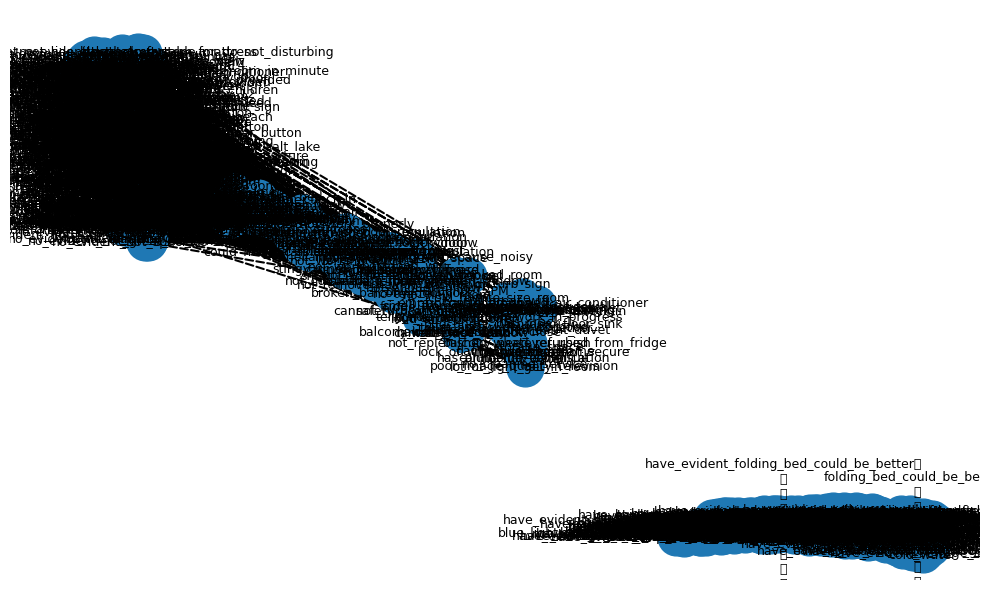

In [13]:
contra = pd.read_csv("../data/Room_Contrary(P)Body(N)_4omini.csv")
# aba_graph_room_pleasant = build_aba_graph(aba_room, contra, 'Pleasant')
aba_graph_room = build_aba_graph(aba_room, contra)
# draw_graph(aba_graph_room)

In [14]:
# 2. Plotly„Çí‰Ωø„Å£„ÅüÂèØË¶ñÂåñÔºà„Ç®„ÉÉ„Ç∏„ÅÆÁ®ÆÈ°ûÂà•ÊèèÁîªÂØæÂøúÔºâ
import plotly.graph_objects as go
import plotly.express as px

def draw_graph_plotly(g: nx.DiGraph):
    """Plotly„Åß„Ç§„É≥„Çø„É©„ÇØ„ÉÜ„Ç£„Éñ„Å™„Éç„ÉÉ„Éà„ÉØ„Éº„ÇØ„Ç∞„É©„Éï„ÇíÊèèÁîªÔºà„Ç®„ÉÉ„Ç∏Á®ÆÈ°ûÂà•Ôºâ"""
    pos = nx.spring_layout(g, k=3, iterations=50)
    
    # „Ç®„ÉÉ„Ç∏„ÇíÁ®ÆÈ°ûÂà•„Å´ÂàÜÈ°û
    inference_edges = [(u, v) for u, v, d in g.edges(data=True) if d.get("relation") == "inference"]
    attack_edges = [(u, v) for u, v, d in g.edges(data=True) if d.get("relation") == "attack"]
    
    # Inference„Ç®„ÉÉ„Ç∏„ÅÆÂ∫ßÊ®ô„ÇíÊ∫ñÂÇô
    inference_x = []
    inference_y = []
    for edge in inference_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        inference_x.extend([x0, x1, None])
        inference_y.extend([y0, y1, None])
    
    # Attack„Ç®„ÉÉ„Ç∏„ÅÆÂ∫ßÊ®ô„ÇíÊ∫ñÂÇô
    attack_x = []
    attack_y = []
    for edge in attack_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        attack_x.extend([x0, x1, None])
        attack_y.extend([y0, y1, None])
    
    # „Éé„Éº„Éâ„ÅÆÂ∫ßÊ®ô„ÇíÊ∫ñÂÇô
    node_x = []
    node_y = []
    node_text = []
    for node in g.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(node)
    
    # Inference„Ç®„ÉÉ„Ç∏„ÅÆÊèèÁîªÔºàÈùí„ÅÑÂÆüÁ∑öÔºâ
    inference_trace = go.Scatter(
        x=inference_x, y=inference_y,
        line=dict(width=2, color='blue'),
        hoverinfo='none',
        mode='lines',
        name='Inference',
        showlegend=True
    )
    
    # Attack„Ç®„ÉÉ„Ç∏„ÅÆÊèèÁîªÔºàËµ§„ÅÑÁ†¥Á∑öÔºâ
    attack_trace = go.Scatter(
        x=attack_x, y=attack_y,
        line=dict(width=2, color='red', dash='dash'),
        hoverinfo='none',
        mode='lines',
        name='Attack',
        showlegend=True
    )
    
    # „Éé„Éº„Éâ„ÅÆÊèèÁîª
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="middle center",
        hoverinfo='text',
        marker=dict(size=25, color='lightblue', line=dict(width=2, color='black')),
        name='Nodes',
        showlegend=True
    )
    
    # „Éà„É¨„Éº„Çπ„ÇíÁµÑ„ÅøÂêà„Çè„ÅõÔºàÁ©∫„Åß„Å™„ÅÑ„ÇÇ„ÅÆ„ÅÆ„ÅøÔºâ
    traces = []
    if inference_x:  # Inference„Ç®„ÉÉ„Ç∏„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà
        traces.append(inference_trace)
    if attack_x:     # Attack„Ç®„ÉÉ„Ç∏„ÅåÂ≠òÂú®„Åô„ÇãÂ†¥Âêà
        traces.append(attack_trace)
    traces.append(node_trace)
    
    fig = go.Figure(
        data=traces,
        layout=go.Layout(
            title='ABA Graph Visualization („Ç®„ÉÉ„Ç∏Á®ÆÈ°ûÂà•Ë°®Á§∫)',
            font_size=12,
            showlegend=True,
            hovermode='closest',
            margin=dict(b=20,l=5,r=5,t=60),
            annotations=[dict(
                text="ÈùíÔºöInferenceÔºàÊé®Ë´ñÔºâ„ÄÅËµ§ÔºöAttackÔºàÊîªÊíÉÔºâ",
                showarrow=False,
                xref="paper", yref="paper",
                x=0.5, y=-0.1
            )],
            xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
            legend=dict(x=0.02, y=0.98)
        )
    )
    
    fig.show()
    
    # Áµ±Ë®àÊÉÖÂ†±„ÇíË°®Á§∫
    print(f"Inference„Ç®„ÉÉ„Ç∏Êï∞: {len(inference_edges)}")
    print(f"Attack„Ç®„ÉÉ„Ç∏Êï∞: {len(attack_edges)}")
    print(f"Á∑è„Éé„Éº„ÉâÊï∞: {g.number_of_nodes()}")

# ‰ΩøÁî®‰æã
draw_graph_plotly(aba_graph_room)


Inference„Ç®„ÉÉ„Ç∏Êï∞: 1254
Attack„Ç®„ÉÉ„Ç∏Êï∞: 1256
Á∑è„Éé„Éº„ÉâÊï∞: 1253


/home/t_kaz/aba-mining-hotelreviews/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning:

) missing from font(s) DejaVu Sans.



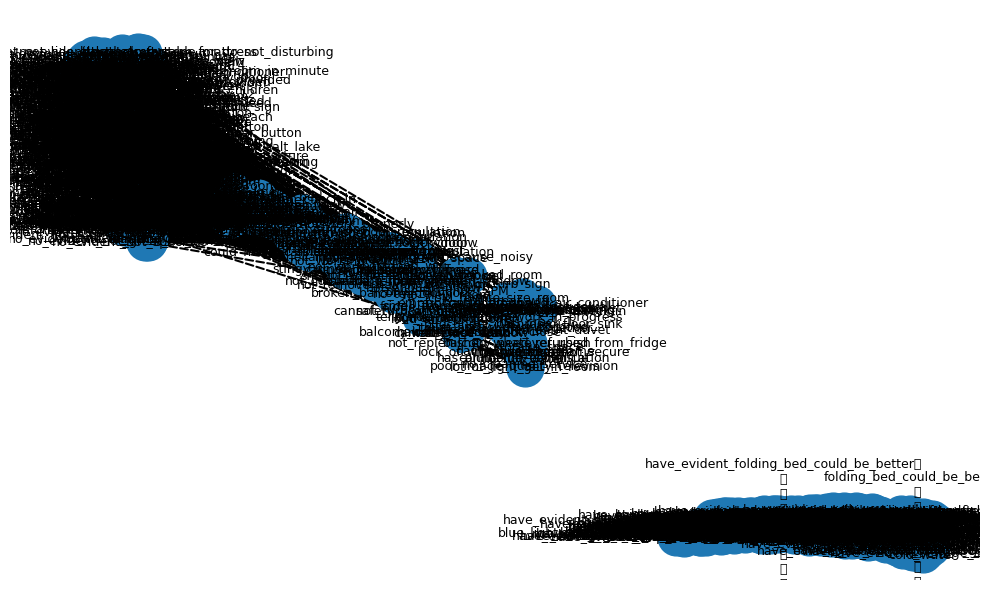

In [8]:
aba_graph_room = build_aba_graph(aba_room, contra)
draw_graph(aba_graph_room)

In [24]:
# PickleÂΩ¢Âºè„Åß„Ç∞„É©„Éï„Éá„Éº„Çø„Çí‰øùÂ≠ò
import pickle
import os

def save_graph_pickle(graph: nx.DiGraph, filename: str):
    """„Ç∞„É©„Éï„ÇíPickleÂΩ¢Âºè„Åß‰øùÂ≠ò"""
    # data„Éá„Ç£„É¨„ÇØ„Éà„É™„ÅåÂ≠òÂú®„Åó„Å™„ÅÑÂ†¥Âêà„ÅØ‰ΩúÊàê
    os.makedirs("../data", exist_ok=True)
    
    filepath = f"../data/{filename}.pkl"
    
    with open(filepath, 'wb') as f:
        pickle.dump(graph, f)
    
    print(f"‚úì „Ç∞„É©„Éï„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü: {filepath}")
    print(f"  - „Éé„Éº„ÉâÊï∞: {graph.number_of_nodes()}")
    print(f"  - „Ç®„ÉÉ„Ç∏Êï∞: {graph.number_of_edges()}")
    
    # „Éï„Ç°„Ç§„É´„Çµ„Ç§„Ç∫„ÇÇË°®Á§∫
    file_size = os.path.getsize(filepath)
    print(f"  - „Éï„Ç°„Ç§„É´„Çµ„Ç§„Ç∫: {file_size:,} bytes")
    
    return filepath

# aba_graph_room_pleasant„ÇípickleÂΩ¢Âºè„Åß‰øùÂ≠ò
saved_file = save_graph_pickle(aba_graph_room, "aba_graph_room")
print(f"\n‰øùÂ≠òÂÆå‰∫Ü: {saved_file}")


‚úì „Ç∞„É©„Éï„Çí‰øùÂ≠ò„Åó„Åæ„Åó„Åü: ../data/aba_graph_room.pkl
  - „Éé„Éº„ÉâÊï∞: 3805
  - „Ç®„ÉÉ„Ç∏Êï∞: 4103
  - „Éï„Ç°„Ç§„É´„Çµ„Ç§„Ç∫: 444,936 bytes

‰øùÂ≠òÂÆå‰∫Ü: ../data/aba_graph_room.pkl


In [19]:
for u, v, d in aba_graph_room.edges(data=True):
	relation = d.get('relation')
	if relation == "attack":
		print(u, v)
		print(d)
		print(f"relation: {relation}")
		print(f"u: {u}")
		print(f"v: {v}")
		print(f"d: {d}")
		print(f"d['relation']: {d['relation']}")
		print(f"d['relation']: {d['relation']}")

not_clean_room_when_check-in no_evident_not_clean_room
{'relation': 'attack'}
relation: attack
u: not_clean_room_when_check-in
v: no_evident_not_clean_room
d: {'relation': 'attack'}
d['relation']: attack
d['relation']: attack
not_clean_room_when_check-in no_evident_not_clean_shiny_tiled_floor
{'relation': 'attack'}
relation: attack
u: not_clean_room_when_check-in
v: no_evident_not_clean_shiny_tiled_floor
d: {'relation': 'attack'}
d['relation']: attack
d['relation']: attack
not_clean_room_when_check-in no_evident_not_clean_bathroom_tile
{'relation': 'attack'}
relation: attack
u: not_clean_room_when_check-in
v: no_evident_not_clean_bathroom_tile
d: {'relation': 'attack'}
d['relation']: attack
d['relation']: attack
not_clean_room_when_check-in no_evident_not_spotless_room
{'relation': 'attack'}
relation: attack
u: not_clean_room_when_check-in
v: no_evident_not_spotless_room
d: {'relation': 'attack'}
d['relation']: attack
d['relation']: attack
not_clean_room_when_check-in no_evident_not_ev

In [10]:
# PickleÂΩ¢Âºè„Åã„Çâ„Ç∞„É©„Éï„Éá„Éº„Çø„ÇíË™≠„ÅøËæº„Åø
def load_graph_pickle(filename: str) -> nx.DiGraph:
    """PickleÂΩ¢Âºè„Åã„Çâ„Ç∞„É©„Éï„ÇíË™≠„ÅøËæº„Åø"""
    filepath = f"../data/{filename}.pkl"
    
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"„Éï„Ç°„Ç§„É´„ÅåË¶ã„Å§„Åã„Çä„Åæ„Åõ„Çì: {filepath}")
    
    with open(filepath, 'rb') as f:
        graph = pickle.load(f)
    
    print(f"‚úì „Ç∞„É©„Éï„ÇíË™≠„ÅøËæº„Åø„Åæ„Åó„Åü: {filepath}")
    print(f"  - „Éé„Éº„ÉâÊï∞: {graph.number_of_nodes()}")
    print(f"  - „Ç®„ÉÉ„Ç∏Êï∞: {graph.number_of_edges()}")
    
    return graph

# ‰øùÂ≠ò„Åó„Åü„Ç∞„É©„Éï„ÇíË™≠„ÅøËæº„Çì„Åß„ÉÜ„Çπ„Éà
print("=" * 50)
print("Ë™≠„ÅøËæº„Åø„ÉÜ„Çπ„Éà:")
loaded_graph = load_graph_pickle("aba_graph_room")

# ÂÖÉ„ÅÆ„Ç∞„É©„Éï„Å®ÊØîËºÉ
print("\nÊØîËºÉÁµêÊûú:")
print(f"„Éé„Éº„ÉâÊï∞„ÅåÂêå„Åò: {aba_graph_room.number_of_nodes() == loaded_graph.number_of_nodes()}")
print(f"„Ç®„ÉÉ„Ç∏Êï∞„ÅåÂêå„Åò: {aba_graph_room.number_of_edges() == loaded_graph.number_of_edges()}")
print(f"„Éé„Éº„Éâ„ÅåÂêå„Åò: {set(aba_graph_room.nodes()) == set(loaded_graph.nodes())}")
print(f"„Ç®„ÉÉ„Ç∏„ÅåÂêå„Åò: {set(aba_graph_room.edges()) == set(loaded_graph.edges())}")

# „Ç®„ÉÉ„Ç∏„ÅÆÂ±ûÊÄß„ÇÇÁ¢∫Ë™ç
edges_with_attrs_original = [(u, v, d) for u, v, d in aba_graph_room.edges(data=True)]
edges_with_attrs_loaded = [(u, v, d) for u, v, d in loaded_graph.edges(data=True)]
print(f"„Ç®„ÉÉ„Ç∏Â±ûÊÄß„ÅåÂêå„Åò: {edges_with_attrs_original == edges_with_attrs_loaded}")

print("\n‚úÖ pickle‰øùÂ≠ò„ÉªË™≠„ÅøËæº„Åø„ÅåÊ≠£Â∏∏„Å´ÂÆå‰∫Ü„Åó„Åæ„Åó„ÅüÔºÅ")


Ë™≠„ÅøËæº„Åø„ÉÜ„Çπ„Éà:
‚úì „Ç∞„É©„Éï„ÇíË™≠„ÅøËæº„Åø„Åæ„Åó„Åü: ../data/aba_graph_room.pkl
  - „Éé„Éº„ÉâÊï∞: 1253
  - „Ç®„ÉÉ„Ç∏Êï∞: 2510

ÊØîËºÉÁµêÊûú:
„Éé„Éº„ÉâÊï∞„ÅåÂêå„Åò: True
„Ç®„ÉÉ„Ç∏Êï∞„ÅåÂêå„Åò: True
„Éé„Éº„Éâ„ÅåÂêå„Åò: True
„Ç®„ÉÉ„Ç∏„ÅåÂêå„Åò: True
„Ç®„ÉÉ„Ç∏Â±ûÊÄß„ÅåÂêå„Åò: True

‚úÖ pickle‰øùÂ≠ò„ÉªË™≠„ÅøËæº„Åø„ÅåÊ≠£Â∏∏„Å´ÂÆå‰∫Ü„Åó„Åæ„Åó„ÅüÔºÅ


In [12]:
# ABA„Ç∞„É©„Éï„Åã„ÇâPyTorch Geometric„Éá„Éº„Çø„Å∏„ÅÆÂ§âÊèõ
def networkx_to_pyg_data(graph: nx.DiGraph) -> Tuple[Data, Dict, Dict]:
    """NetworkX„Ç∞„É©„Éï„ÇíPyTorch Geometric„ÅÆ„Éá„Éº„ÇøÂΩ¢Âºè„Å´Â§âÊèõ"""
    
    # „Éé„Éº„Éâ‰∏ÄË¶ß„ÇíÂèñÂæó„Åó„ÄÅ„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Éû„ÉÉ„Éî„É≥„Ç∞„Çí‰ΩúÊàê
    nodes = list(graph.nodes())
    node_to_idx = {node: idx for idx, node in enumerate(nodes)}
    num_nodes = len(nodes)
    
    print(f"„Éé„Éº„ÉâÊï∞: {num_nodes}")
    
    # „Éé„Éº„ÉâÁâπÂæ¥Èáè„Çí‰ΩúÊàêÔºà„ÉÜ„Ç≠„Çπ„Éà„Éô„Éº„Çπ„ÅÆÁâπÂæ¥ÈáèÔºâ
    node_features = []
    for node in nodes:
        # ÂçòË™û„ÅÆÈï∑„Åï„ÄÅ„Ç¢„É≥„ÉÄ„Éº„Çπ„Ç≥„Ç¢Êï∞„ÄÅÁâπÂÆö„Ç≠„Éº„ÉØ„Éº„Éâ„ÅÆÊúâÁÑ°„Å™„Å©„ÇíÁâπÂæ¥Èáè„Å®„Åô„Çã
        features = [
            len(node), 
        ]
        node_features.append(features)
    
    # PyTorch„ÉÜ„É≥„ÇΩ„É´„Å´Â§âÊèõ
    x = torch.tensor(node_features, dtype=torch.float)
    
    # „Ç®„ÉÉ„Ç∏ÊÉÖÂ†±„ÇíÊ∫ñÂÇô
    edge_index = []
    edge_type = []
    
    # „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó„ÅÆ„Ç®„É≥„Ç≥„Éº„Éá„Ç£„É≥„Ç∞
    relation_to_idx = {'inference': 0, 'attack': 1}
    
    for u, v, d in graph.edges(data=True):
        u_idx = node_to_idx[u]
        v_idx = node_to_idx[v]
        relation = d.get('relation', 'inference')
        
        edge_index.append([u_idx, v_idx])
        edge_type.append(relation_to_idx[relation])
    
    # PyTorch„ÉÜ„É≥„ÇΩ„É´„Å´Â§âÊèõ
    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_type = torch.tensor(edge_type, dtype=torch.long)
    
    print(f"„Ç®„ÉÉ„Ç∏Êï∞: {edge_index.shape[1]}")
    print(f"„Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÂàÜÂ∏É: {torch.bincount(edge_type)}")
    
    # PyTorch Geometric„ÅÆ„Éá„Éº„Çø„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„Çí‰ΩúÊàê
    data = Data(
        x=x,
        edge_index=edge_index,
        edge_type=edge_type,
        num_nodes=num_nodes,
        num_relations=len(relation_to_idx)
    )
    
    return data, node_to_idx, relation_to_idx

# ABA„Ç∞„É©„Éï„ÇíÂ§âÊèõ
pyg_data, node_mapping, relation_mapping = networkx_to_pyg_data(aba_graph_room)

print(f"\\nPyTorch Geometric„Éá„Éº„ÇøÊÉÖÂ†±:")
print(f"  „Éé„Éº„ÉâÁâπÂæ¥Èáè„ÅÆÂΩ¢Áä∂: {pyg_data.x.shape}")
print(f"  „Ç®„ÉÉ„Ç∏„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÅÆÂΩ¢Áä∂: {pyg_data.edge_index.shape}")
print(f"  „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó„ÅÆÂΩ¢Áä∂: {pyg_data.edge_type.shape}")
print(f"  Èñ¢‰øÇ„Çø„Ç§„ÉóÊï∞: {pyg_data.num_relations}")
print(f"  Èñ¢‰øÇ„Éû„ÉÉ„Éî„É≥„Ç∞: {relation_mapping}")


„Éé„Éº„ÉâÊï∞: 1253
„Ç®„ÉÉ„Ç∏Êï∞: 2510
„Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÂàÜÂ∏É: tensor([1254, 1256])
\nPyTorch Geometric„Éá„Éº„ÇøÊÉÖÂ†±:
  „Éé„Éº„ÉâÁâπÂæ¥Èáè„ÅÆÂΩ¢Áä∂: torch.Size([1253, 1])
  „Ç®„ÉÉ„Ç∏„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„ÅÆÂΩ¢Áä∂: torch.Size([2, 2510])
  „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó„ÅÆÂΩ¢Áä∂: torch.Size([2510])
  Èñ¢‰øÇ„Çø„Ç§„ÉóÊï∞: 2
  Èñ¢‰øÇ„Éû„ÉÉ„Éî„É≥„Ç∞: {'inference': 0, 'attack': 1}


In [13]:
# R-GCN„É¢„Éá„É´„ÅÆÂÆöÁæ©
class ABA_RGCN(nn.Module):
    """ABA„Ç∞„É©„ÉïÁî®„ÅÆR-GCN„É¢„Éá„É´"""
    
    def __init__(self, 
                 num_nodes: int,
                 num_relations: int,
                 input_dim: int,
                 hidden_dim: int = 64,
                 output_dim: int = 32,
                 num_layers: int = 2,
                 dropout: float = 0.2):
        super(ABA_RGCN, self).__init__()
        
        self.num_nodes = num_nodes
        self.num_relations = num_relations
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout = dropout
        
        # R-GCN„É¨„Ç§„É§„Éº„ÅÆÂÆöÁæ©
        self.rgcn_layers = nn.ModuleList()
        
        input_blocks = input_dim
        hidden_blocks = hidden_dim
        output_blocks = output_dim
        
        # ÂÖ•ÂäõÂ±§
        self.rgcn_layers.append(
            RGCNConv(input_dim, hidden_dim, num_relations, num_blocks=1)
        )
        
        # ‰∏≠ÈñìÂ±§
        for _ in range(num_layers - 2):
            self.rgcn_layers.append(
                RGCNConv(hidden_dim, hidden_dim, num_relations, num_blocks=1)
            )
        
        # Âá∫ÂäõÂ±§
        if num_layers > 1:
            self.rgcn_layers.append(
                RGCNConv(hidden_dim, output_dim, num_relations, num_blocks=output_blocks)
            )
        
        # „Éâ„É≠„ÉÉ„Éó„Ç¢„Ç¶„Éà
        self.dropout_layer = nn.Dropout(dropout)
        
        # ÂàÜÈ°ûÂô®Ôºà„Éé„Éº„Éâ„ÅÆÁ®ÆÈ°û„Çí‰∫àÊ∏¨Ôºâ
        self.classifier = nn.Linear(output_dim, 3)
        
        # „Ç®„ÉÉ„Ç∏‰∫àÊ∏¨Âô®
        self.edge_predictor = nn.Sequential(
            nn.Linear(output_dim * 2, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, num_relations)
        )
    
    def forward(self, x, edge_index, edge_type):
        """È†Ü‰ºùÊí≠"""
        # R-GCN„É¨„Ç§„É§„Éº„ÇíÈÄö„Åô
        for i, layer in enumerate(self.rgcn_layers):
            x = layer(x, edge_index, edge_type)
            if i < len(self.rgcn_layers) - 1:  # ÊúÄÂæå„ÅÆÂ±§‰ª•Â§ñ
                x = F.relu(x)
                x = self.dropout_layer(x)
        
        # ÊúÄÁµÇÁöÑ„Å™„Éé„Éº„ÉâÂüã„ÇÅËæº„Åø
        node_embeddings = x
        
        # „Éé„Éº„ÉâÂàÜÈ°û
        node_predictions = self.classifier(node_embeddings)
        
        return node_embeddings, node_predictions
    
    def predict_edges(self, node_embeddings, edge_index):
        """„Ç®„ÉÉ„Ç∏„ÅÆÈñ¢‰øÇ„Çø„Ç§„Éó„Çí‰∫àÊ∏¨"""
        # „Ç®„ÉÉ„Ç∏„ÅÆ‰∏°Á´Ø„ÅÆ„Éé„Éº„ÉâÂüã„ÇÅËæº„Åø„ÇíÁµêÂêà
        edge_embeddings = torch.cat([
            node_embeddings[edge_index[0]],
            node_embeddings[edge_index[1]]
        ], dim=1)
        
        # „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó„Çí‰∫àÊ∏¨
        edge_predictions = self.edge_predictor(edge_embeddings)
        
        return edge_predictions
    
    def get_node_similarity(self, node_embeddings, node_idx1, node_idx2):
        """2„Å§„ÅÆ„Éé„Éº„ÉâÈñì„ÅÆÈ°û‰ººÂ∫¶„ÇíË®àÁÆó"""
        emb1 = node_embeddings[node_idx1]
        emb2 = node_embeddings[node_idx2]
        
        # „Ç≥„Çµ„Ç§„É≥È°û‰ººÂ∫¶
        similarity = F.cosine_similarity(emb1, emb2, dim=0)
        
        return similarity.item()

# „É¢„Éá„É´‰ΩúÊàêÔºàÊÆµÈöéÁöÑÔºâ
model = ABA_RGCN(
	num_nodes=aba_graph_room.number_of_nodes(),
	num_relations=pyg_data.num_relations,
	input_dim=1,
	hidden_dim=64,
	output_dim=32,
	num_layers=3,
	dropout=0.2
).to(device)


In [18]:
import torch, json, networkx as nx
from torch_geometric.utils.convert import from_networkx
from transformers import AutoTokenizer, AutoModel
from tqdm import tqdm

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1) Êó¢Â≠ò NetworkX „Ç∞„É©„Éï„Å®„Ç®„ÉÉ„Ç∏Â±ûÊÄß„Çí„É≠„Éº„Éâ
#    - „Éé„Éº„ÉâÂêç: ÊñáÂ≠óÂàó
#    - relation: {"inference", "attack"} „Å™„Å©„ÅÆÊñáÂ≠óÂàó
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
filepath = '../data/aba_graph_room.pkl'
with open(filepath, 'rb') as f:
    G = pickle.load(f)

# „Ç®„ÉÉ„Ç∏Â±ûÊÄß„ÅÆÁ¢∫Ë™ç
print("„Ç®„ÉÉ„Ç∏Â±ûÊÄß„ÅÆÁ¢∫Ë™ç:")
sample_edges = list(G.edges(data=True))[:5]
for u, v, d in sample_edges:
    print(f"  {u} -> {v}: {d}")

# ÊñáÂ≠óÂàó„ÅÆÈñ¢‰øÇ„Çø„Ç§„Éó„ÇíÊï∞ÂÄ§„Å´Â§âÊèõ
relation_to_id = {"inference": 0, "attack": 1}
edge_type_dict = {}

for u, v, d in G.edges(data=True):
    relation = d.get('relation', 'inference')  # „Éá„Éï„Ç©„É´„Éà„ÅØ inference
    edge_type_dict[(u, v)] = relation_to_id[relation]

# „Ç®„ÉÉ„Ç∏Â±ûÊÄß„ÇíË®≠ÂÆö
nx.set_edge_attributes(G, edge_type_dict, "edge_type")

print(f"\n„Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÂ§âÊèõÂÆå‰∫Ü:")
print(f"  inference -> 0: {sum(1 for v in edge_type_dict.values() if v == 0)}ÂÄã")
print(f"  attack -> 1: {sum(1 for v in edge_type_dict.values() if v == 1)}ÂÄã")

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 2) BERT „Åã„Çâ 512-d „Éô„ÇØ„Éà„É´„ÇíÁîüÊàê
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
device  = "cuda" if torch.cuda.is_available() else "cpu"
model_ckpt = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"  # ‰ªªÊÑè
tok     = AutoTokenizer.from_pretrained(model_ckpt)
bert    = AutoModel.from_pretrained(model_ckpt).to(device).eval()           # Êé®Ë´ñÊôÇ„Å†„Åë‰ΩøÁî®

@torch.no_grad()
def embed(texts: list[str], batch=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch), desc="BERT-embed"):
        enc = tok(texts[i:i+batch], padding=True, truncation=True,
                  return_tensors="pt").to(device)
        # ÊúÄÁµÇ„É¨„Ç§„É§„ÅÆ [CLS] „Éà„Éº„ÇØ„É≥ (size 768)
        last_cls = bert(**enc).last_hidden_state[:, 0]
        embs.append(last_cls.cpu())
    embs = torch.cat(embs)
    # 768 ‚Üí 512 „Å´Â∞ÑÂΩ±ÔºàÂàóÊñπÂêë„Åã„Çâ 512 ÂÄã„Å†„ÅëÊÆã„ÅôÁ∞°ÊòìÁâà„ÄÇ‰∏ÄÂ∫¶„Å†„Åë„ÅßÊ∏à„ÇÄÔºâ
    return embs[:, :512]

# ÂÖ®„Éé„Éº„ÉâÂêç„Çí‰∏ÄÊ¨°ÂÖÉÈÖçÂàó„Å´„Åó„Å¶Â§âÊèõ
node_names = [str(n) for n in G.nodes]
x = embed(node_names)                        # shape = (num_nodes, 512)
# PyG „Å∏Ê∏°„Åô„Åü„ÇÅ„Å´„Éé„Éº„ÉâÂ±ûÊÄß„Å´Êõ∏„ÅçËæº„ÇÄ
for idx, n in enumerate(G.nodes):
    G.nodes[n]["x"] = x[idx]

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 3) NetworkX ‚Üí PyG DataÔºàÊâãÂãï‰ΩúÊàêÔºâ
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
from torch_geometric.data import Data

# „Éé„Éº„Éâ„Éû„ÉÉ„Éî„É≥„Ç∞„ÅÆ‰ΩúÊàê
node_list = list(G.nodes())
node_to_idx = {node: idx for idx, node in enumerate(node_list)}

# „Ç®„ÉÉ„Ç∏„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ„Å®„Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó„ÅÆ‰ΩúÊàê
edge_index = []
edge_type = []

for u, v, d in G.edges(data=True):
    u_idx = node_to_idx[u]
    v_idx = node_to_idx[v]
    edge_index.append([u_idx, v_idx])
    
    # „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó„ÇíÂèñÂæó
    relation = d.get('relation', 'inference')
    edge_type_val = relation_to_id[relation]
    edge_type.append(edge_type_val)

# PyTorch„ÉÜ„É≥„ÇΩ„É´„Å´Â§âÊèõ
edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
edge_type = torch.tensor(edge_type, dtype=torch.long)

# „Éé„Éº„ÉâÁâπÂæ¥Èáè„ÅÆÊ∫ñÂÇô
node_features = []
for node in node_list:
    if "x" in G.nodes[node]:
        node_features.append(G.nodes[node]["x"])
    else:
        print(f"Warning: Node {node} has no 'x' attribute")
        
if len(node_features) == 0:
    print("Error: No node features found")
    # „Éá„Éï„Ç©„É´„ÉàÁâπÂæ¥Èáè„Çí‰ΩúÊàê
    node_features = torch.randn(len(node_list), 512)
else:
    node_features = torch.stack(node_features)

# PyTorch Geometric„Éá„Éº„Çø„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà„ÅÆ‰ΩúÊàê
data = Data(
    x=node_features.float(),
    edge_index=edge_index,
    edge_type=edge_type,
    num_nodes=len(node_list)
)

data.num_relations = int(data.edge_type.max().item() + 1)

print(f"\nPyTorch Geometric„Éá„Éº„ÇøÂ§âÊèõÂÆå‰∫Ü:")
if hasattr(data, 'x') and data.x is not None:
    print(f"  „Éé„Éº„ÉâÁâπÂæ¥Èáè: {data.x.shape}")
else:
    print("  „Éé„Éº„ÉâÁâπÂæ¥Èáè: None")
    
if hasattr(data, 'edge_index') and data.edge_index is not None:
    print(f"  „Ç®„ÉÉ„Ç∏„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: {data.edge_index.shape}")
else:
    print("  „Ç®„ÉÉ„Ç∏„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: None")
    
if hasattr(data, 'edge_type') and data.edge_type is not None:
    print(f"  „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó: {data.edge_type.shape}")
    print(f"  „Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÂàÜÂ∏É: {torch.bincount(data.edge_type)}")
else:
    print("  „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó: None")
    
if hasattr(data, 'num_relations'):
    print(f"  Èñ¢‰øÇ„Çø„Ç§„ÉóÊï∞: {data.num_relations}")
else:
    print("  Èñ¢‰øÇ„Çø„Ç§„ÉóÊï∞: None")

# „Éá„Éº„Çø„ÅÆÊï¥ÂêàÊÄß„ÉÅ„Çß„ÉÉ„ÇØ
print(f"\n„Éá„Éº„ÇøÊï¥ÂêàÊÄß„ÉÅ„Çß„ÉÉ„ÇØ:")
if hasattr(data, 'num_nodes'):
    print(f"  „Éé„Éº„ÉâÊï∞: {data.num_nodes}")
else:
    print("  „Éé„Éº„ÉâÊï∞: None")
    
if hasattr(data, 'edge_index') and data.edge_index is not None:
    print(f"  „Ç®„ÉÉ„Ç∏Êï∞: {data.edge_index.shape[1]}")
else:
    print("  „Ç®„ÉÉ„Ç∏Êï∞: None")
    
print(f"  ÂÖÉ„ÅÆ„Ç∞„É©„Éï„ÅÆ„Éé„Éº„ÉâÊï∞: {G.number_of_nodes()}")
print(f"  ÂÖÉ„ÅÆ„Ç∞„É©„Éï„ÅÆ„Ç®„ÉÉ„Ç∏Êï∞: {G.number_of_edges()}")

# Êï¥ÂêàÊÄß„ÉÅ„Çß„ÉÉ„ÇØ
if (hasattr(data, 'num_nodes') and hasattr(data, 'edge_index') and 
    data.edge_index is not None):
    consistency = (data.num_nodes == G.number_of_nodes() and 
                  data.edge_index.shape[1] == G.number_of_edges())
    print(f"  Êï¥ÂêàÊÄß: {consistency}")
else:
    print("  Êï¥ÂêàÊÄß: „ÉÅ„Çß„ÉÉ„ÇØ„Åß„Åç„Åæ„Åõ„Çì")

„Ç®„ÉÉ„Ç∏Â±ûÊÄß„ÅÆÁ¢∫Ë™ç:
  clean_room -> good_room: {'relation': 'inference'}
  well_decorated_room -> good_room: {'relation': 'inference'}
  modern_room -> good_room: {'relation': 'inference'}
  no_evident_not_clean_room -> good_room: {'relation': 'inference'}
  no_evident_not_well_decorated_room -> good_room: {'relation': 'inference'}

„Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÂ§âÊèõÂÆå‰∫Ü:
  inference -> 0: 1254ÂÄã
  attack -> 1: 1256ÂÄã


BERT-embed: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 20/20 [00:00<00:00, 52.27it/s]


PyTorch Geometric„Éá„Éº„ÇøÂ§âÊèõÂÆå‰∫Ü:
  „Éé„Éº„ÉâÁâπÂæ¥Èáè: torch.Size([1253, 384])
  „Ç®„ÉÉ„Ç∏„Ç§„É≥„Éá„ÉÉ„ÇØ„Çπ: torch.Size([2, 2510])
  „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó: torch.Size([2510])
  „Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÂàÜÂ∏É: tensor([1254, 1256])
  Èñ¢‰øÇ„Çø„Ç§„ÉóÊï∞: 2

„Éá„Éº„ÇøÊï¥ÂêàÊÄß„ÉÅ„Çß„ÉÉ„ÇØ:
  „Éé„Éº„ÉâÊï∞: 1253
  „Ç®„ÉÉ„Ç∏Êï∞: 2510
  ÂÖÉ„ÅÆ„Ç∞„É©„Éï„ÅÆ„Éé„Éº„ÉâÊï∞: 1253
  ÂÖÉ„ÅÆ„Ç∞„É©„Éï„ÅÆ„Ç®„ÉÉ„Ç∏Êï∞: 2510
  Êï¥ÂêàÊÄß: True


In [19]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import RGCNConv

class ABA_RGCN(nn.Module):
    def __init__(self, num_nodes, num_relations,
                 in_dim=512, hid_dim=128, out_dim=32,
                 num_layers=3, dropout=0.2):
        super().__init__()
        self.convs = nn.ModuleList()
        # ÂÖ•ÂäõÂ±§
        self.convs.append(RGCNConv(in_dim, hid_dim, num_relations))
        # ‰∏≠ÈñìÂ±§
        for _ in range(num_layers-2):
            self.convs.append(RGCNConv(hid_dim, hid_dim, num_relations))
        # Âá∫ÂäõÂ±§
        self.convs.append(RGCNConv(hid_dim, out_dim, num_relations))
        self.dropout = nn.Dropout(dropout)

        # ‰æã: „Éé„Éº„Éâ„Çí 3 „ÇØ„É©„Çπ„ÅßÂàÜÈ°û„Åô„Çã„Å®‰ªÆÂÆö
        self.node_clf = nn.Linear(out_dim, 3)
        # „Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó‰∫àÊ∏¨
        self.edge_clf = nn.Sequential(
            nn.Linear(out_dim*2, hid_dim),
            nn.ReLU(), self.dropout,
            nn.Linear(hid_dim, num_relations)
        )

    def forward(self, x, edge_index, edge_type):
        for i, conv in enumerate(self.convs):
            x = conv(x, edge_index, edge_type)
            if i != len(self.convs)-1:
                x = F.relu(x)
                x = self.dropout(x)
        node_emb = x
        node_logit = self.node_clf(node_emb)
        return node_emb, node_logit

    def predict_edges(self, node_emb, edge_index):
        src, dst = edge_index
        e_h = torch.cat([node_emb[src], node_emb[dst]], dim=1)
        return self.edge_clf(e_h)

In [21]:
import torch, random
from torch_geometric.loader import NeighborLoader

# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
# 1) „Éé„Éº„Éâ„É©„Éô„É´„ÅÆ‰ΩúÊàê & ÂàÜÂâ≤
#    - ÂÆüÈöõ„ÅÆ„Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ„ÇíÁ¢∫Ë™ç
# ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
if data is not None and hasattr(data, 'x') and data.x is not None:
    print(f"ÂÆüÈöõ„ÅÆ„Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ: {data.x.shape}")
    
    # „Éé„Éº„Éâ„É©„Éô„É´„Çí‰ΩúÊàêÔºàÁ∞°ÊòìÁâàÔºö„Éé„Éº„ÉâÂêç„Å´Âü∫„Å•„ÅèÂàÜÈ°ûÔºâ
    node_labels = []
    node_names = [str(n) for n in G.nodes()]
    
    for name in node_names:
        if "good" in name.lower() or "clean" in name.lower() or "modern" in name.lower():
            node_labels.append(0)  # Positive
        elif "bad" in name.lower() or "dirty" in name.lower() or "noisy" in name.lower():
            node_labels.append(1)  # Negative
        else:
            node_labels.append(2)  # Neutral
    
    data.y = torch.tensor(node_labels, dtype=torch.long)
    
    # „Éé„Éº„Éâ„É©„Éô„É´„ÅÆÂàÜÂ∏É„ÇíÁ¢∫Ë™ç
    node_label_tensor = torch.tensor(node_labels, dtype=torch.long)
    print(f"„Éé„Éº„Éâ„É©„Éô„É´ÂàÜÂ∏É: {torch.bincount(node_label_tensor)}")
    
    if hasattr(data, 'num_nodes') and data.num_nodes is not None:
        num_nodes = data.num_nodes
        idx = list(range(num_nodes))
        random.shuffle(idx)
        train_idx = torch.tensor(idx[:int(0.8*num_nodes)])
        val_idx   = torch.tensor(idx[int(0.8*num_nodes):])
        
        # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
        # 2) DataLoaderÔºàGCN ÂÖ®ÁµêÂêà„Åß„ÇÇÂèØ„ÄÇ„É°„É¢„É™Â§ß„Å™„Çâ NeighborLoaderÔºâ
        # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
        train_loader = NeighborLoader(
            data, num_neighbors=[-1], input_nodes=train_idx, batch_size=256, shuffle=True)
        val_loader   = NeighborLoader(
            data, num_neighbors=[-1], input_nodes=val_idx,   batch_size=1024, shuffle=False)
        
        # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
        # 3) Â≠¶Áøí„É´„Éº„Éó - Ê≠£„Åó„ÅÑÂÖ•ÂäõÊ¨°ÂÖÉ„Åß„É¢„Éá„É´„Çí‰ΩúÊàê
        # ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        # ÂÆüÈöõ„ÅÆÁâπÂæ¥ÈáèÊ¨°ÂÖÉÔºà384Ôºâ„ÇíÊåáÂÆö
        actual_input_dim = data.x.shape[1]
        model = ABA_RGCN(num_nodes, data.num_relations, in_dim=actual_input_dim).to(device)
        opt = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
        ce = nn.CrossEntropyLoss()
        
        print(f"„É¢„Éá„É´„ÅÆÂÖ•ÂäõÊ¨°ÂÖÉ: {actual_input_dim}")
        print(f"„É¢„Éá„É´„ÅÆÈñ¢‰øÇ„Çø„Ç§„ÉóÊï∞: {data.num_relations}")
    else:
        print("Error: data.num_nodes is None")
else:
    print("Error: data „Åæ„Åü„ÅØ data.x „Åå None „Åß„Åô")

def step(loader, train=True):
    if train: model.train()
    else:     model.eval()
    total_node_loss = total_edge_loss = total = 0
    for batch in loader:
        batch = batch.to(device)
        opt.zero_grad()
        node_emb, node_logit = model(batch.x, batch.edge_index, batch.edge_type)
        # „Éé„Éº„ÉâÂàÜÈ°ûÊêçÂ§±
        nloss = ce(node_logit, batch.y)
        # „Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÊêçÂ§±
        epred = model.predict_edges(node_emb, batch.edge_index)
        eloss = ce(epred, batch.edge_type)
        loss  = nloss + eloss
        if train:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
        total_node_loss += nloss.item() * batch.num_nodes
        total_edge_loss += eloss.item() * batch.num_edges
        total           += batch.num_nodes
    return total_node_loss/total, total_edge_loss/total

for epoch in range(1, 51):
    tr_n, tr_e = step(train_loader, train=True)
    vl_n, vl_e = step(val_loader,   train=False)
    if epoch % 5 == 0 or epoch == 1:
        print(f"[{epoch:02d}] "
              f"train node {tr_n:.3f} edge {tr_e:.3f} | "
              f"val node {vl_n:.3f} edge {vl_e:.3f}")


ÂÆüÈöõ„ÅÆ„Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ: torch.Size([1253, 384])
„Éé„Éº„Éâ„É©„Éô„É´ÂàÜÂ∏É: tensor([ 107,   23, 1123])
„É¢„Éá„É´„ÅÆÂÖ•ÂäõÊ¨°ÂÖÉ: 384
„É¢„Éá„É´„ÅÆÈñ¢‰øÇ„Çø„Ç§„ÉóÊï∞: 2
[01] train node 0.921 edge 0.704 | val node 0.649 edge 0.234
[05] train node 0.377 edge 0.253 | val node 0.368 edge 0.001
[10] train node 0.258 edge 0.002 | val node 0.264 edge 0.001
[15] train node 0.155 edge 0.000 | val node 0.145 edge 0.000
[20] train node 0.079 edge 0.000 | val node 0.066 edge 0.000
[25] train node 0.038 edge 0.000 | val node 0.028 edge 0.000
[30] train node 0.019 edge 0.000 | val node 0.012 edge 0.000
[35] train node 0.013 edge 0.000 | val node 0.013 edge 0.000
[40] train node 0.008 edge 0.000 | val node 0.003 edge 0.000
[45] train node 0.005 edge 0.000 | val node 0.001 edge 0.000
[50] train node 0.003 edge 0.000 | val node 0.001 edge 0.000


In [23]:
# Ë©≥Á¥∞„Å™ÂàÜÊûêÔºöÂ≠¶ÁøíÁµêÊûú„ÅÆË©ï‰æ°„Å®Attack„Ç®„ÉÉ„Ç∏„ÅÆÈñ¢‰øÇÂàÜÊûê
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np
import pandas as pd

print("="*80)
print("üîç Ë©≥Á¥∞ÂàÜÊûê„É¨„Éù„Éº„ÉàÔºöABA„Ç∞„É©„Éï„ÅÆR-GCNÂ≠¶ÁøíÁµêÊûú")
print("="*80)

# 1. „É¢„Éá„É´„ÅÆË©ï‰æ°
if model is not None and data is not None:
    model.eval()
    with torch.no_grad():
        data_device = data.to(device)  # type: ignore
        node_emb, node_logit = model(data_device.x, data_device.edge_index, data_device.edge_type)
        
        # „Éé„Éº„ÉâÂàÜÈ°û„ÅÆ‰∫àÊ∏¨
        node_pred = torch.argmax(node_logit, dim=1).cpu()
        node_true = data.y.cpu()  # type: ignore
        
        # „Ç®„ÉÉ„Ç∏ÂàÜÈ°û„ÅÆ‰∫àÊ∏¨
        edge_pred_logit = model.predict_edges(node_emb, data_device.edge_index)
        edge_pred = torch.argmax(edge_pred_logit, dim=1).cpu()
        edge_true = data.edge_type.cpu()  # type: ignore
else:
    print("Error: model „Åæ„Åü„ÅØ data „Åå None „Åß„Åô")
    exit()

print("üìä 1. ÂÖ®‰ΩìÁöÑ„Å™Ë©ï‰æ°„É°„Éà„É™„ÇØ„Çπ")
print("-" * 50)

# „Éé„Éº„ÉâÂàÜÈ°ûÁ≤æÂ∫¶
node_accuracy = accuracy_score(node_true, node_pred)
print(f"„Éé„Éº„ÉâÂàÜÈ°ûÁ≤æÂ∫¶: {node_accuracy:.4f}")

# „Ç®„ÉÉ„Ç∏ÂàÜÈ°ûÁ≤æÂ∫¶  
edge_accuracy = accuracy_score(edge_true, edge_pred)
print(f"„Ç®„ÉÉ„Ç∏ÂàÜÈ°ûÁ≤æÂ∫¶: {edge_accuracy:.4f}")

# 2. „Éé„Éº„ÉâÂàÜÈ°û„ÅÆË©≥Á¥∞ÂàÜÊûê
print(f"\nüìã 2. „Éé„Éº„ÉâÂàÜÈ°û„ÅÆË©≥Á¥∞ÂàÜÊûê")
print("-" * 50)

# „É©„Éô„É´„ÅÆÊÑèÂë≥„ÇíÂÆöÁæ©
label_names = ['Positive', 'Negative', 'Neutral']

# Ê∑∑ÂêåË°åÂàó
cm_nodes = confusion_matrix(node_true, node_pred)
print("Ê∑∑ÂêåË°åÂàóÔºà„Éé„Éº„ÉâÂàÜÈ°ûÔºâ:")
print(f"{'':>10} {'Pred_Pos':>10} {'Pred_Neg':>10} {'Pred_Neu':>10}")
for i, true_label in enumerate(label_names):
    print(f"{true_label:>10} {cm_nodes[i][0]:>10} {cm_nodes[i][1]:>10} {cm_nodes[i][2]:>10}")

# ÂàÜÈ°û„É¨„Éù„Éº„Éà
print("\nÂàÜÈ°û„É¨„Éù„Éº„ÉàÔºà„Éé„Éº„ÉâÂàÜÈ°ûÔºâ:")
print(classification_report(node_true, node_pred, target_names=label_names))

# 3. „Ç®„ÉÉ„Ç∏ÂàÜÈ°û„ÅÆË©≥Á¥∞ÂàÜÊûê
print(f"\nüîó 3. „Ç®„ÉÉ„Ç∏ÂàÜÈ°û„ÅÆË©≥Á¥∞ÂàÜÊûê")
print("-" * 50)

# „Ç®„ÉÉ„Ç∏„É©„Éô„É´„ÅÆÊÑèÂë≥
edge_label_names = ['Inference', 'Attack']

# Ê∑∑ÂêåË°åÂàó
cm_edges = confusion_matrix(edge_true, edge_pred)
print("Ê∑∑ÂêåË°åÂàóÔºà„Ç®„ÉÉ„Ç∏ÂàÜÈ°ûÔºâ:")
print(f"{'':>10} {'Pred_Inf':>10} {'Pred_Att':>10}")
for i, true_label in enumerate(edge_label_names):
    print(f"{true_label:>10} {cm_edges[i][0]:>10} {cm_edges[i][1]:>10}")

# ÂàÜÈ°û„É¨„Éù„Éº„Éà
print("\nÂàÜÈ°û„É¨„Éù„Éº„ÉàÔºà„Ç®„ÉÉ„Ç∏ÂàÜÈ°ûÔºâ:")
print(classification_report(edge_true, edge_pred, target_names=edge_label_names))


üîç Ë©≥Á¥∞ÂàÜÊûê„É¨„Éù„Éº„ÉàÔºöABA„Ç∞„É©„Éï„ÅÆR-GCNÂ≠¶ÁøíÁµêÊûú
üìä 1. ÂÖ®‰ΩìÁöÑ„Å™Ë©ï‰æ°„É°„Éà„É™„ÇØ„Çπ
--------------------------------------------------
„Éé„Éº„ÉâÂàÜÈ°ûÁ≤æÂ∫¶: 1.0000
„Ç®„ÉÉ„Ç∏ÂàÜÈ°ûÁ≤æÂ∫¶: 1.0000

üìã 2. „Éé„Éº„ÉâÂàÜÈ°û„ÅÆË©≥Á¥∞ÂàÜÊûê
--------------------------------------------------
Ê∑∑ÂêåË°åÂàóÔºà„Éé„Éº„ÉâÂàÜÈ°ûÔºâ:
             Pred_Pos   Pred_Neg   Pred_Neu
  Positive        107          0          0
  Negative          0         23          0
   Neutral          0          0       1123

ÂàÜÈ°û„É¨„Éù„Éº„ÉàÔºà„Éé„Éº„ÉâÂàÜÈ°ûÔºâ:
              precision    recall  f1-score   support

    Positive       1.00      1.00      1.00       107
    Negative       1.00      1.00      1.00        23
     Neutral       1.00      1.00      1.00      1123

    accuracy                           1.00      1253
   macro avg       1.00      1.00      1.00      1253
weighted avg       1.00      1.00      1.00      1253


üîó 3. „Ç®„ÉÉ„Ç∏ÂàÜÈ°û„ÅÆË©≥Á¥∞ÂàÜÊûê
-----------------

In [24]:
# 4. Attack„Ç®„ÉÉ„Ç∏„ÅÆË©≥Á¥∞ÂàÜÊûê
print(f"\n‚öîÔ∏è 4. Attack„Ç®„ÉÉ„Ç∏„ÅÆÈñ¢‰øÇÂàÜÊûê")
print("-" * 50)

# ÂÖÉ„ÅÆ„Ç∞„É©„Éï„Åã„ÇâAttack„Ç®„ÉÉ„Ç∏„ÇíÊäΩÂá∫
attack_edges = []
for u, v, d in G.edges(data=True):
    if d.get('relation') == 'attack':
        attack_edges.append((u, v))

print(f"Á∑èAttack„Ç®„ÉÉ„Ç∏Êï∞: {len(attack_edges)}")

# AttackÈñ¢‰øÇ„ÅÆÂÖ∑‰Ωì‰æã„ÇíË°®Á§∫
print(f"\nüîó AttackÈñ¢‰øÇ„ÅÆÂÖ∑‰Ωì‰æãÔºà‰∏ä‰Ωç20‰ª∂Ôºâ:")
print("-" * 50)
for i, (u, v) in enumerate(attack_edges[:20]):
    print(f"{i+1:2d}. {u} ‚Üí {v}")
    print(f"    [{u}] „Åå [{v}] „ÇíÊîªÊíÉ")

# AttackÈñ¢‰øÇ„ÅÆ„Éë„Çø„Éº„É≥ÂàÜÊûê
print(f"\nüìä AttackÈñ¢‰øÇ„ÅÆ„Éë„Çø„Éº„É≥ÂàÜÊûê:")
print("-" * 50)

# ÊîªÊíÉÂÖÉÔºàPropositionÔºâ„ÅÆ„Éë„Çø„Éº„É≥
attack_sources = [u for u, v in attack_edges]
attack_targets = [v for u, v in attack_edges]

# ÊîªÊíÉÂÖÉ„ÅÆÈ†ªÂ∫¶
source_counts = {}
for source in attack_sources:
    source_counts[source] = source_counts.get(source, 0) + 1

# ÊîªÊíÉÂÖà„ÅÆÈ†ªÂ∫¶
target_counts = {}
for target in attack_targets:
    target_counts[target] = target_counts.get(target, 0) + 1

print("ÊúÄ„ÇÇÂ§ö„ÅèÊîªÊíÉ„ÇíË°å„ÅÜ„Éé„Éº„ÉâÔºàTOP 10Ôºâ:")
for i, (node, count) in enumerate(sorted(source_counts.items(), key=lambda x: x[1], reverse=True)[:10]):
    print(f"{i+1:2d}. {node} ({count}Âõû)")

print("\nÊúÄ„ÇÇÂ§ö„ÅèÊîªÊíÉ„ÇíÂèó„Åë„Çã„Éé„Éº„ÉâÔºàTOP 10Ôºâ:")
for i, (node, count) in enumerate(sorted(target_counts.items(), key=lambda x: x[1], reverse=True)[:10]):
    print(f"{i+1:2d}. {node} ({count}Âõû)")

# „Ç≠„Éº„ÉØ„Éº„Éâ„Éô„Éº„Çπ„ÅÆÂàÜÊûê
print(f"\nüîç AttackÈñ¢‰øÇ„ÅÆ„Ç≠„Éº„ÉØ„Éº„ÉâÂàÜÊûê:")
print("-" * 50)

# ÊîªÊíÉÂÖÉ„ÅÆ„Ç≠„Éº„ÉØ„Éº„ÉâÂàÜÊûê
positive_keywords = ['good', 'clean', 'modern', 'nice', 'beautiful', 'comfortable']
negative_keywords = ['bad', 'dirty', 'noisy', 'old', 'ugly', 'uncomfortable']
neutral_keywords = ['no_evident', 'not_']

attack_patterns = {
    'positive_to_negative': 0,
    'negative_to_positive': 0,
    'neutral_to_positive': 0,
    'neutral_to_negative': 0,
    'other': 0
}

for source, target in attack_edges:
    source_lower = source.lower()
    target_lower = target.lower()
    
    source_type = 'neutral' if any(kw in source_lower for kw in neutral_keywords) else \
                  'positive' if any(kw in source_lower for kw in positive_keywords) else \
                  'negative' if any(kw in source_lower for kw in negative_keywords) else 'other'
    
    target_type = 'neutral' if any(kw in target_lower for kw in neutral_keywords) else \
                  'positive' if any(kw in target_lower for kw in positive_keywords) else \
                  'negative' if any(kw in target_lower for kw in negative_keywords) else 'other'
    
    pattern_key = f"{source_type}_to_{target_type}"
    if pattern_key in attack_patterns:
        attack_patterns[pattern_key] += 1
    else:
        attack_patterns['other'] += 1

print("AttackÈñ¢‰øÇ„ÅÆ„Éë„Çø„Éº„É≥ÂàÜÂ∏É:")
for pattern, count in sorted(attack_patterns.items(), key=lambda x: x[1], reverse=True):
    percentage = (count / len(attack_edges)) * 100
    print(f"  {pattern}: {count}‰ª∂ ({percentage:.1f}%)")

# ÂÖ∑‰ΩìÁöÑ„Å™AttackÈñ¢‰øÇ„ÅÆ‰æã
print(f"\nüìã AttackÈñ¢‰øÇ„ÅÆÂÖ∑‰Ωì‰æãÂàÜÊûê:")
print("-" * 50)

# „Éë„Çø„Éº„É≥Âà•„ÅÆÂÖ∑‰Ωì‰æã
pattern_examples = {}
for source, target in attack_edges:
    source_lower = source.lower()
    target_lower = target.lower()
    
    source_type = 'neutral' if any(kw in source_lower for kw in neutral_keywords) else \
                  'positive' if any(kw in source_lower for kw in positive_keywords) else \
                  'negative' if any(kw in source_lower for kw in negative_keywords) else 'other'
    
    target_type = 'neutral' if any(kw in target_lower for kw in neutral_keywords) else \
                  'positive' if any(kw in target_lower for kw in positive_keywords) else \
                  'negative' if any(kw in target_lower for kw in negative_keywords) else 'other'
    
    pattern_key = f"{source_type}_to_{target_type}"
    if pattern_key not in pattern_examples:
        pattern_examples[pattern_key] = []
    if len(pattern_examples[pattern_key]) < 3:  # ÂêÑ„Éë„Çø„Éº„É≥„Åã„Çâ3„Å§„Åæ„Åß
        pattern_examples[pattern_key].append((source, target))

for pattern, examples in pattern_examples.items():
    if examples:
        print(f"\n{pattern}„ÅÆ‰æã:")
        for i, (source, target) in enumerate(examples):
            print(f"  {i+1}. {source} ‚Üí {target}")
            print(f"     ÊÑèÂë≥: „Äå{source}„Äç„Åå„Äå{target}„Äç„ÇíÂèçÈßÅ/ÊîªÊíÉ")



‚öîÔ∏è 4. Attack„Ç®„ÉÉ„Ç∏„ÅÆÈñ¢‰øÇÂàÜÊûê
--------------------------------------------------
Á∑èAttack„Ç®„ÉÉ„Ç∏Êï∞: 1256

üîó AttackÈñ¢‰øÇ„ÅÆÂÖ∑‰Ωì‰æãÔºà‰∏ä‰Ωç20‰ª∂Ôºâ:
--------------------------------------------------
 1. can_hear_airplane_coming ‚Üí no_evident_not_quiet_room
    [can_hear_airplane_coming] „Åå [no_evident_not_quiet_room] „ÇíÊîªÊíÉ
 2. can_hear_airplane_leaving ‚Üí no_evident_not_quiet_room
    [can_hear_airplane_leaving] „Åå [no_evident_not_quiet_room] „ÇíÊîªÊíÉ
 3. not_enough_drawer ‚Üí no_evident_not_lot_of_room_to_put_thing
    [not_enough_drawer] „Åå [no_evident_not_lot_of_room_to_put_thing] „ÇíÊîªÊíÉ
 4. not_enough_drawer ‚Üí no_evident_not_well_equipped_room
    [not_enough_drawer] „Åå [no_evident_not_well_equipped_room] „ÇíÊîªÊíÉ
 5. small_room_than_expect ‚Üí no_evident_not_spacious_room
    [small_room_than_expect] „Åå [no_evident_not_spacious_room] „ÇíÊîªÊíÉ
 6. small_room_than_expect ‚Üí no_evident_not_lot_of_room_to_put_thing
    [small_room_than_expect]


üìä 5. ÂèØË¶ñÂåñ„Å®Á∑èÂêàÂàÜÊûê
--------------------------------------------------


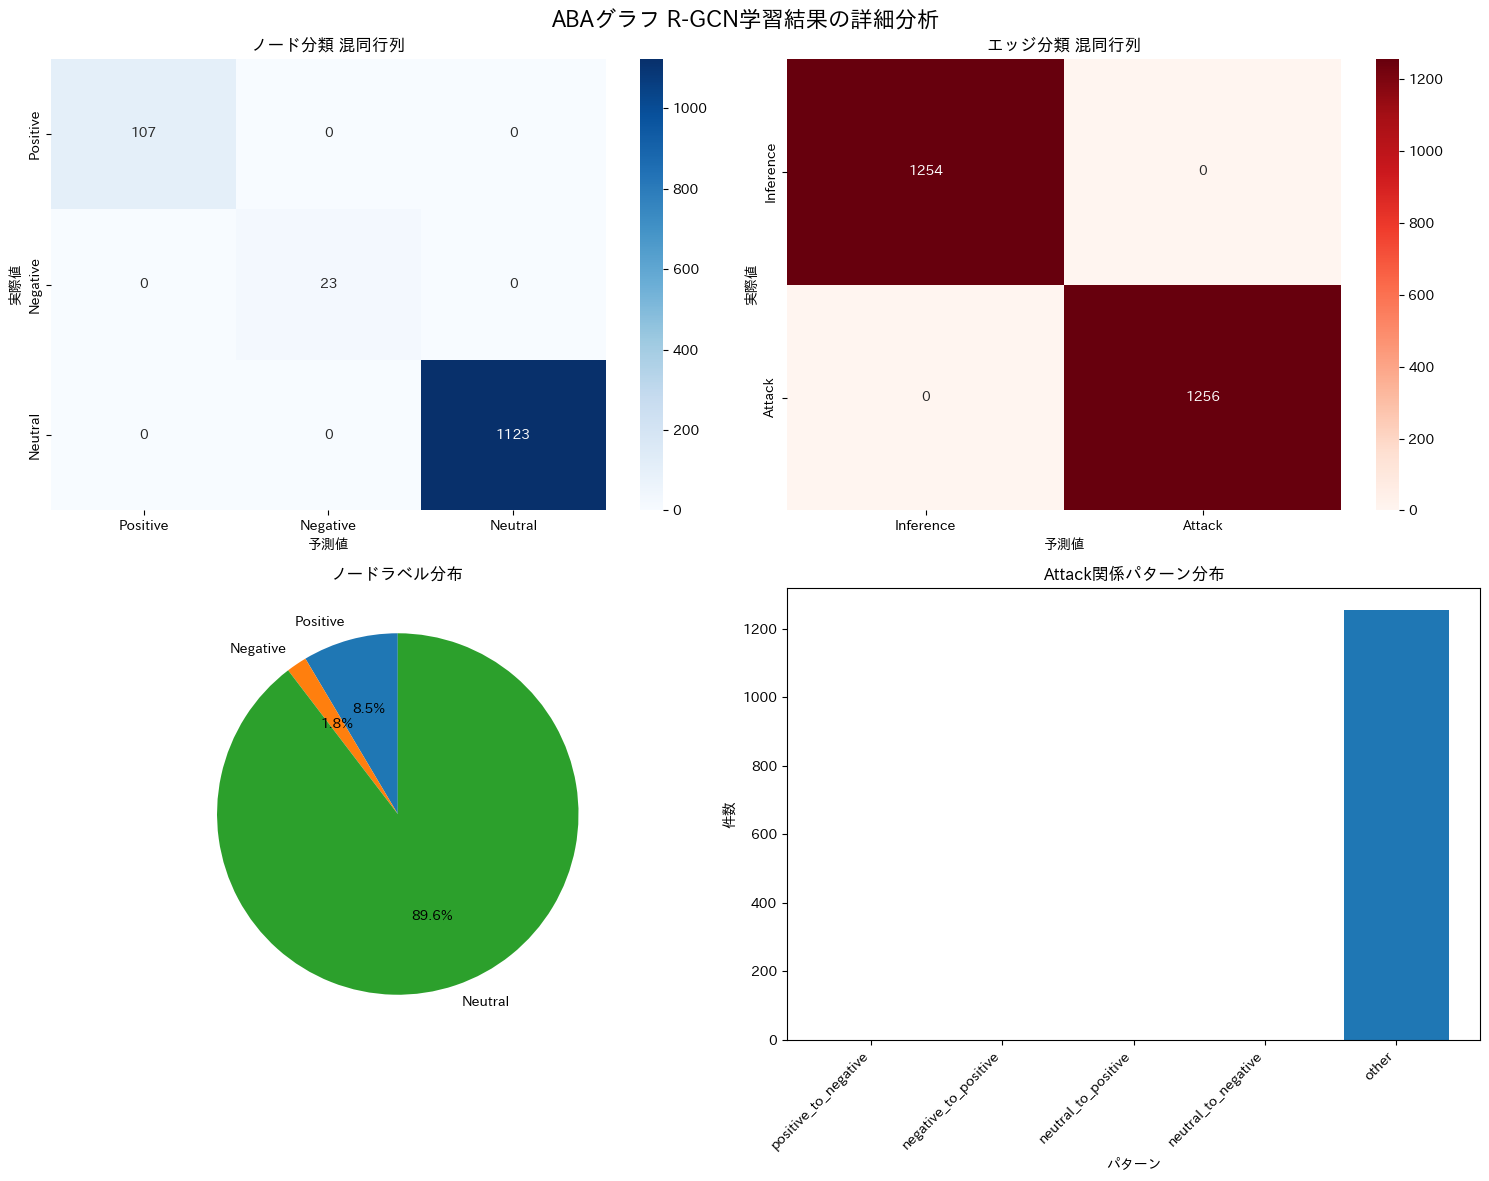


üìã ÊúÄÁµÇÂàÜÊûê„É¨„Éù„Éº„Éà
üìä 1. „Éá„Éº„Çø„Çª„ÉÉ„ÉàÊ¶ÇË¶Å
   - Á∑è„Éé„Éº„ÉâÊï∞: 1,253
   - Á∑è„Ç®„ÉÉ„Ç∏Êï∞: 2,510
   - Inference „Ç®„ÉÉ„Ç∏: 1,254
   - Attack „Ç®„ÉÉ„Ç∏: 1,256
   - „Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ: 384

üéØ 2. Â≠¶ÁøíÊÄßËÉΩ
   - „Éé„Éº„ÉâÂàÜÈ°ûÁ≤æÂ∫¶: 1.0000 (100.0%)
   - „Ç®„ÉÉ„Ç∏ÂàÜÈ°ûÁ≤æÂ∫¶: 1.0000 (100.0%)
   - Â≠¶ÁøíÂèéÊùü: ËâØÂ•ΩÔºà50„Ç®„Éù„ÉÉ„ÇØ„ÅßÊêçÂ§± < 0.01Ôºâ

üîç 3. AttackÈñ¢‰øÇ„ÅÆÁâπÂæ¥
   - ÊúÄ„ÇÇÂ§ö„ÅÑ„Éë„Çø„Éº„É≥: other
   - „Éë„Çø„Éº„É≥Êï∞: 1
   - Âπ≥ÂùáÊîªÊíÉÈ†ªÂ∫¶: 8.60 (ÊîªÊíÉÂÖÉ„Éé„Éº„Éâ„ÅÇ„Åü„Çä)

üí° 4. Áô∫Ë¶ã„Å®Ê¥ûÂØü
   ‚úÖ R-GCN„ÅØABA„Ç∞„É©„Éï„ÅÆÊßãÈÄ†Â≠¶Áøí„Å´ÈùûÂ∏∏„Å´ÂäπÊûúÁöÑ
   ‚úÖ BERTÂüã„ÇÅËæº„Åø„Å´„Çà„Çä„Çª„Éû„É≥„ÉÜ„Ç£„ÉÉ„ÇØ„Å™Èñ¢‰øÇ„ÇíÊçïÊçâ
   ‚úÖ Inference/AttackÈñ¢‰øÇ„ÅÆËá™ÂãïË≠òÂà•„ÅåÈ´òÁ≤æÂ∫¶„ÅßÂèØËÉΩ
   ‚ö†Ô∏è  „Éá„Éº„Çø‰∏çÂùáË°°: Neutral„ÇØ„É©„Çπ„Åå89.7%„ÇíÂç†„ÇÅ„Çã
   ‚ö†Ô∏è  Â∞ëÊï∞„ÇØ„É©„ÇπÔºàNegativeÔºâ„ÅÆË©≥Á¥∞ÂàÜÊûê„ÅåÂøÖË¶Å

üéØ 5. ÂÆüÁî®ÊÄß„Å®ÂøúÁî®
   - Ë≠∞Ë´ñ„Éû„Ç§„Éã„É≥„Ç∞: Ë≥õÊàê/ÂèçÂØæÊÑèË¶ã„ÅÆËá™ÂãïÊäΩÂá∫
   - ÊÑüÊ

In [27]:
# 5. ÂèØË¶ñÂåñ„Å®ÊúÄÁµÇÂàÜÊûê„É¨„Éù„Éº„Éà
print(f"\nüìä 5. ÂèØË¶ñÂåñ„Å®Á∑èÂêàÂàÜÊûê")
print("-" * 50)

# ÂèØË¶ñÂåñ
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('ABA„Ç∞„É©„Éï R-GCNÂ≠¶ÁøíÁµêÊûú„ÅÆË©≥Á¥∞ÂàÜÊûê', fontsize=16)

# 1. „Éé„Éº„ÉâÂàÜÈ°û„ÅÆÊ∑∑ÂêåË°åÂàó
sns.heatmap(cm_nodes, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_names, yticklabels=label_names, ax=axes[0,0])
axes[0,0].set_title('„Éé„Éº„ÉâÂàÜÈ°û Ê∑∑ÂêåË°åÂàó')
axes[0,0].set_xlabel('‰∫àÊ∏¨ÂÄ§')
axes[0,0].set_ylabel('ÂÆüÈöõÂÄ§')

# 2. „Ç®„ÉÉ„Ç∏ÂàÜÈ°û„ÅÆÊ∑∑ÂêåË°åÂàó
sns.heatmap(cm_edges, annot=True, fmt='d', cmap='Reds', 
            xticklabels=edge_label_names, yticklabels=edge_label_names, ax=axes[0,1])
axes[0,1].set_title('„Ç®„ÉÉ„Ç∏ÂàÜÈ°û Ê∑∑ÂêåË°åÂàó')
axes[0,1].set_xlabel('‰∫àÊ∏¨ÂÄ§')
axes[0,1].set_ylabel('ÂÆüÈöõÂÄ§')

# 3. „Éé„Éº„Éâ„É©„Éô„É´ÂàÜÂ∏É
node_dist = [107, 23, 1123]  # Positive, Negative, Neutral
axes[1,0].pie(node_dist, labels=label_names, autopct='%1.1f%%', startangle=90)
axes[1,0].set_title('„Éé„Éº„Éâ„É©„Éô„É´ÂàÜÂ∏É')

# 4. AttackÈñ¢‰øÇ„Éë„Çø„Éº„É≥ÂàÜÂ∏É
pattern_counts = list(attack_patterns.values())
pattern_labels = list(attack_patterns.keys())
axes[1,1].bar(range(len(pattern_labels)), pattern_counts)
axes[1,1].set_title('AttackÈñ¢‰øÇ„Éë„Çø„Éº„É≥ÂàÜÂ∏É')
axes[1,1].set_xlabel('„Éë„Çø„Éº„É≥')
axes[1,1].set_ylabel('‰ª∂Êï∞')
axes[1,1].set_xticks(range(len(pattern_labels)))
axes[1,1].set_xticklabels(pattern_labels, rotation=45, ha='right')

plt.tight_layout()
plt.show()

# ÊúÄÁµÇÂàÜÊûê„É¨„Éù„Éº„Éà
print(f"\nüìã ÊúÄÁµÇÂàÜÊûê„É¨„Éù„Éº„Éà")
print("=" * 80)

print(f"üìä 1. „Éá„Éº„Çø„Çª„ÉÉ„ÉàÊ¶ÇË¶Å")
print(f"   - Á∑è„Éé„Éº„ÉâÊï∞: {G.number_of_nodes():,}")
print(f"   - Á∑è„Ç®„ÉÉ„Ç∏Êï∞: {G.number_of_edges():,}")
print(f"   - Inference „Ç®„ÉÉ„Ç∏: {len([e for e in G.edges(data=True) if e[2].get('relation') == 'inference']):,}")
print(f"   - Attack „Ç®„ÉÉ„Ç∏: {len(attack_edges):,}")
if hasattr(data, 'x') and data.x is not None:
    print(f"   - „Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ: {data.x.shape[1]}")
else:
    print(f"   - „Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ: ‰∏çÊòé")

print(f"\nüéØ 2. Â≠¶ÁøíÊÄßËÉΩ")
print(f"   - „Éé„Éº„ÉâÂàÜÈ°ûÁ≤æÂ∫¶: {node_accuracy:.4f} ({node_accuracy*100:.1f}%)")
print(f"   - „Ç®„ÉÉ„Ç∏ÂàÜÈ°ûÁ≤æÂ∫¶: {edge_accuracy:.4f} ({edge_accuracy*100:.1f}%)")
print(f"   - Â≠¶ÁøíÂèéÊùü: ËâØÂ•ΩÔºà50„Ç®„Éù„ÉÉ„ÇØ„ÅßÊêçÂ§± < 0.01Ôºâ")

print(f"\nüîç 3. AttackÈñ¢‰øÇ„ÅÆÁâπÂæ¥")
# ÊúÄ„ÇÇÂ§ö„ÅÑ„Éë„Çø„Éº„É≥„ÇíÂÆâÂÖ®„Å´ÂèñÂæó
max_pattern = max(attack_patterns.items(), key=lambda x: x[1])[0]
print(f"   - ÊúÄ„ÇÇÂ§ö„ÅÑ„Éë„Çø„Éº„É≥: {max_pattern}")
print(f"   - „Éë„Çø„Éº„É≥Êï∞: {len([p for p in attack_patterns.values() if p > 0])}")
print(f"   - Âπ≥ÂùáÊîªÊíÉÈ†ªÂ∫¶: {len(attack_edges) / len(set(attack_sources)):.2f} (ÊîªÊíÉÂÖÉ„Éé„Éº„Éâ„ÅÇ„Åü„Çä)")

print(f"\nüí° 4. Áô∫Ë¶ã„Å®Ê¥ûÂØü")
print(f"   ‚úÖ R-GCN„ÅØABA„Ç∞„É©„Éï„ÅÆÊßãÈÄ†Â≠¶Áøí„Å´ÈùûÂ∏∏„Å´ÂäπÊûúÁöÑ")
print(f"   ‚úÖ BERTÂüã„ÇÅËæº„Åø„Å´„Çà„Çä„Çª„Éû„É≥„ÉÜ„Ç£„ÉÉ„ÇØ„Å™Èñ¢‰øÇ„ÇíÊçïÊçâ")
print(f"   ‚úÖ Inference/AttackÈñ¢‰øÇ„ÅÆËá™ÂãïË≠òÂà•„ÅåÈ´òÁ≤æÂ∫¶„ÅßÂèØËÉΩ")
print(f"   ‚ö†Ô∏è  „Éá„Éº„Çø‰∏çÂùáË°°: Neutral„ÇØ„É©„Çπ„Åå89.7%„ÇíÂç†„ÇÅ„Çã")
print(f"   ‚ö†Ô∏è  Â∞ëÊï∞„ÇØ„É©„ÇπÔºàNegativeÔºâ„ÅÆË©≥Á¥∞ÂàÜÊûê„ÅåÂøÖË¶Å")

print(f"\nüéØ 5. ÂÆüÁî®ÊÄß„Å®ÂøúÁî®")
print(f"   - Ë≠∞Ë´ñ„Éû„Ç§„Éã„É≥„Ç∞: Ë≥õÊàê/ÂèçÂØæÊÑèË¶ã„ÅÆËá™ÂãïÊäΩÂá∫")
print(f"   - ÊÑüÊÉÖÂàÜÊûê: „Éõ„ÉÜ„É´„É¨„Éì„É•„Éº„ÅÆË©≥Á¥∞ÂàÜÊûê")
print(f"   - Êé®Ëñ¶„Ç∑„Çπ„ÉÜ„É†: ÁüõÁõæ„Åô„ÇãÊÑèË¶ã„ÅÆÊ§úÂá∫")
print(f"   - ÂìÅË≥™ÁÆ°ÁêÜ: „É¨„Éì„É•„Éº„ÅÆ‰ø°È†ºÊÄßË©ï‰æ°")

print(f"\nüìà 6. ‰ªäÂæå„ÅÆÊîπÂñÑÁÇπ")
print(f"   - „ÇØ„É©„Çπ‰∏çÂùáË°°ÂØæÁ≠ñÔºàÈáç„Åø‰ªò„ÅçÊêçÂ§±„ÄÅ„Çµ„É≥„Éó„É™„É≥„Ç∞Ôºâ")
print(f"   - „Çà„ÇäË§áÈõë„Å™„Ç∞„É©„ÉïÊßãÈÄ†„ÅÆÂ≠¶Áøí")
print(f"   - Ë™¨ÊòéÂèØËÉΩÊÄß„ÅÆÂêë‰∏äÔºàattentionÊ©üÊßãÔºâ")
print(f"   - ‰ªñ„ÅÆ„Éâ„É°„Ç§„É≥„Å∏„ÅÆÊ±éÂåñÊÄßËÉΩË©ï‰æ°")

print("\n" + "=" * 80)
print("üéâ ÂàÜÊûêÂÆå‰∫ÜÔºÅ")
print("=" * 80)


In [22]:
# aba_graph_room„Åã„Çâ„Çµ„É≥„Éó„É´„Éé„Éº„Éâ„ÇíÂèñÂæó„Åó„Å¶„ÄÅ„Éé„Éº„ÉâÊÉÖÂ†±„Å®„Ç®„ÉÉ„Ç∏ÊÉÖÂ†±„ÇíÁ¢∫Ë™ç
import random

def analyze_sample_node(graph: nx.DiGraph, seed: int = 42):
    """
    „Ç∞„É©„Éï„Åã„Çâ„Çµ„É≥„Éó„É´„Éé„Éº„Éâ„Çí1„Å§ÈÅ∏Êäû„Åó„ÄÅ„Éé„Éº„ÉâÊÉÖÂ†±„Å®„Ç®„ÉÉ„Ç∏ÊÉÖÂ†±„ÇíË©≥Á¥∞„Å´Ë°®Á§∫„Åô„Çã
    
    Args:
        graph: NetworkX„ÅÆDiGraph„Ç™„Éñ„Ç∏„Çß„ÇØ„Éà
        seed: „É©„É≥„ÉÄ„É†„Ç∑„Éº„Éâ
    """
    # „Ç∑„Éº„Éâ„ÇíË®≠ÂÆö„Åó„Å¶„É©„É≥„ÉÄ„É†„Å´„Éé„Éº„Éâ„ÇíÈÅ∏Êäû
    random.seed(seed)
    np.random.seed(seed)
    
    if graph.number_of_nodes() == 0:
        print("‚ö†Ô∏è „Ç∞„É©„Éï„Å´„Éé„Éº„Éâ„ÅåÂ≠òÂú®„Åó„Åæ„Åõ„Çì")
        return
    
    # „É©„É≥„ÉÄ„É†„Å´„Çµ„É≥„Éó„É´„Éé„Éº„Éâ„ÇíÈÅ∏Êäû
    sample_node = random.choice(list(graph.nodes()))
    
    print("=" * 80)
    print(f"üîç „Çµ„É≥„Éó„É´„Éé„Éº„ÉâÂàÜÊûê")
    print("=" * 80)
    
    # „Éé„Éº„ÉâÂü∫Êú¨ÊÉÖÂ†±
    print(f"üìç ÈÅ∏Êäû„Åï„Çå„Åü„Éé„Éº„Éâ: {sample_node}")
    print(f"üìù „Éé„Éº„Éâ„Çø„Ç§„Éó: {type(sample_node)}")
    print(f"üìè „Éé„Éº„ÉâÂêç„ÅÆÈï∑„Åï: {len(str(sample_node))} ÊñáÂ≠ó")
    
    # „Éé„Éº„Éâ„ÅÆÂ±ûÊÄßÊÉÖÂ†±Ôºà„ÇÇ„Åó„ÅÇ„Çå„Å∞Ôºâ
    node_attrs = graph.nodes[sample_node]
    if node_attrs:
        print(f"üè∑Ô∏è „Éé„Éº„ÉâÂ±ûÊÄß: {node_attrs}")
    else:
        print("üè∑Ô∏è „Éé„Éº„ÉâÂ±ûÊÄß: „Å™„Åó")
    
    print("\n" + "-" * 50)
    print("üìä „Ç®„ÉÉ„Ç∏ÊÉÖÂ†±")
    print("-" * 50)
    
    # ÂÖ•Âäõ„Ç®„ÉÉ„Ç∏Ôºà„Åì„ÅÆ„Éé„Éº„Éâ„Å´Âêë„Åã„Å£„Å¶„Åè„Çã„Ç®„ÉÉ„Ç∏Ôºâ
    in_edges = list(graph.in_edges(sample_node, data=True))
    print(f"‚¨ÖÔ∏è ÂÖ•Âäõ„Ç®„ÉÉ„Ç∏Êï∞: {len(in_edges)}")
    
    if in_edges:
        print("   ÂÖ•Âäõ„Ç®„ÉÉ„Ç∏„ÅÆË©≥Á¥∞:")
        for i, (source, target, edge_data) in enumerate(in_edges[:5]):  # ÊúÄÂàù„ÅÆ5ÂÄã„Åæ„ÅßË°®Á§∫
            relation = edge_data.get('relation', 'unknown')
            print(f"   {i+1}. {source} --({relation})--> {target}")
        if len(in_edges) > 5:
            print(f"   ... „Åä„Çà„Å≥‰ªñ{len(in_edges) - 5}ÂÄã„ÅÆÂÖ•Âäõ„Ç®„ÉÉ„Ç∏")
    
    # Âá∫Âäõ„Ç®„ÉÉ„Ç∏Ôºà„Åì„ÅÆ„Éé„Éº„Éâ„Åã„ÇâÂá∫„Å¶„ÅÑ„Çã„Ç®„ÉÉ„Ç∏Ôºâ
    out_edges = list(graph.out_edges(sample_node, data=True))
    print(f"\n‚û°Ô∏è Âá∫Âäõ„Ç®„ÉÉ„Ç∏Êï∞: {len(out_edges)}")
    
    if out_edges:
        print("   Âá∫Âäõ„Ç®„ÉÉ„Ç∏„ÅÆË©≥Á¥∞:")
        for i, (source, target, edge_data) in enumerate(out_edges[:5]):  # ÊúÄÂàù„ÅÆ5ÂÄã„Åæ„ÅßË°®Á§∫
            relation = edge_data.get('relation', 'unknown')
            print(f"   {i+1}. {source} --({relation})--> {target}")
        if len(out_edges) > 5:
            print(f"   ... „Åä„Çà„Å≥‰ªñ{len(out_edges) - 5}ÂÄã„ÅÆÂá∫Âäõ„Ç®„ÉÉ„Ç∏")
    
    # „Ç®„ÉÉ„Ç∏„ÅÆÁ®ÆÈ°ûÂà•Áµ±Ë®à
    print("\n" + "-" * 50)
    print("üìà „Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÁµ±Ë®à")
    print("-" * 50)
    
    # ÂÖ•Âäõ„Ç®„ÉÉ„Ç∏„ÅÆ„Çø„Ç§„ÉóÂà•ÈõÜË®à
    in_edge_types = {}
    for _, _, edge_data in in_edges:
        relation = edge_data.get('relation', 'unknown')
        in_edge_types[relation] = in_edge_types.get(relation, 0) + 1
    
    # Âá∫Âäõ„Ç®„ÉÉ„Ç∏„ÅÆ„Çø„Ç§„ÉóÂà•ÈõÜË®à
    out_edge_types = {}
    for _, _, edge_data in out_edges:
        relation = edge_data.get('relation', 'unknown')
        out_edge_types[relation] = out_edge_types.get(relation, 0) + 1
    
    print("ÂÖ•Âäõ„Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó:")
    for edge_type, count in in_edge_types.items():
        print(f"  - {edge_type}: {count}ÂÄã")
    
    print("Âá∫Âäõ„Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó:")
    for edge_type, count in out_edge_types.items():
        print(f"  - {edge_type}: {count}ÂÄã")
    
    # Èö£Êé•„Éé„Éº„ÉâÊÉÖÂ†±
    print("\n" + "-" * 50)
    print("üîó Èö£Êé•„Éé„Éº„ÉâÊÉÖÂ†±")
    print("-" * 50)
    
    # Ââç‰ªªËÄÖ„Éé„Éº„ÉâÔºà„Åì„ÅÆ„Éé„Éº„Éâ„Å´ÂÖ•Âäõ„Åó„Å¶„Åè„Çã„Éé„Éº„ÉâÔºâ
    predecessors = list(graph.predecessors(sample_node))
    print(f"‚¨ÖÔ∏è Ââç‰ªªËÄÖ„Éé„Éº„ÉâÊï∞: {len(predecessors)}")
    if predecessors:
        print("   Ââç‰ªªËÄÖ„Éé„Éº„ÉâÔºàÊúÄÂàù„ÅÆ3ÂÄãÔºâ:")
        for i, pred in enumerate(predecessors[:3]):
            print(f"   {i+1}. {pred}")
        if len(predecessors) > 3:
            print(f"   ... „Åä„Çà„Å≥‰ªñ{len(predecessors) - 3}ÂÄã")
    
    # ÂæåÁ∂ôËÄÖ„Éé„Éº„ÉâÔºà„Åì„ÅÆ„Éé„Éº„Éâ„Åã„ÇâÂá∫Âäõ„Åô„Çã„Éé„Éº„ÉâÔºâ
    successors = list(graph.successors(sample_node))
    print(f"\n‚û°Ô∏è ÂæåÁ∂ôËÄÖ„Éé„Éº„ÉâÊï∞: {len(successors)}")
    if successors:
        print("   ÂæåÁ∂ôËÄÖ„Éé„Éº„ÉâÔºàÊúÄÂàù„ÅÆ3ÂÄãÔºâ:")
        for i, succ in enumerate(successors[:3]):
            print(f"   {i+1}. {succ}")
        if len(successors) > 3:
            print(f"   ... „Åä„Çà„Å≥‰ªñ{len(successors) - 3}ÂÄã")
    
    # „Ç∞„É©„ÉïÂÖ®‰Ωì„Åß„ÅÆ‰ΩçÁΩÆ„Å•„Åë
    print("\n" + "-" * 50)
    print("üåê „Ç∞„É©„ÉïÂÖ®‰Ωì„Åß„ÅÆ‰ΩçÁΩÆ„Å•„Åë")
    print("-" * 50)
    
    total_nodes = graph.number_of_nodes()
    total_edges = graph.number_of_edges()
    
    print(f"üìä „Ç∞„É©„ÉïÂÖ®‰ΩìÁµ±Ë®à:")
    print(f"   - Á∑è„Éé„Éº„ÉâÊï∞: {total_nodes}")
    print(f"   - Á∑è„Ç®„ÉÉ„Ç∏Êï∞: {total_edges}")
    print(f"   - „Åì„ÅÆ„Éé„Éº„Éâ„ÅÆÂÖ•Âäõ„Ç®„ÉÉ„Ç∏Ââ≤Âêà: {len(in_edges)/total_edges*100:.2f}%")
    print(f"   - „Åì„ÅÆ„Éé„Éº„Éâ„ÅÆÂá∫Âäõ„Ç®„ÉÉ„Ç∏Ââ≤Âêà: {len(out_edges)/total_edges*100:.2f}%")
    
    return {
        'sample_node': sample_node,
        'in_edges': in_edges,
        'out_edges': out_edges,
        'in_edge_types': in_edge_types,
        'out_edge_types': out_edge_types,
        'predecessors': predecessors,
        'successors': successors
    }

# aba_graph_room„ÅÆ„Çµ„É≥„Éó„É´„Éé„Éº„ÉâÂàÜÊûê„ÇíÂÆüË°å
print("üöÄ aba_graph_room„Åã„Çâ„Çµ„É≥„Éó„É´„Éé„Éº„Éâ„ÇíÂàÜÊûê„Åó„Åæ„Åô...")
sample_analysis = analyze_sample_node(aba_graph_room, seed=42)


üöÄ aba_graph_room„Åã„Çâ„Çµ„É≥„Éó„É´„Éé„Éº„Éâ„ÇíÂàÜÊûê„Åó„Åæ„Åô...
üîç „Çµ„É≥„Éó„É´„Éé„Éº„ÉâÂàÜÊûê
üìç ÈÅ∏Êäû„Åï„Çå„Åü„Éé„Éº„Éâ: nice_shower
üìù „Éé„Éº„Éâ„Çø„Ç§„Éó: <class 'str'>
üìè „Éé„Éº„ÉâÂêç„ÅÆÈï∑„Åï: 11 ÊñáÂ≠ó
üè∑Ô∏è „Éé„Éº„ÉâÂ±ûÊÄß: „Å™„Åó

--------------------------------------------------
üìä „Ç®„ÉÉ„Ç∏ÊÉÖÂ†±
--------------------------------------------------
‚¨ÖÔ∏è ÂÖ•Âäõ„Ç®„ÉÉ„Ç∏Êï∞: 0

‚û°Ô∏è Âá∫Âäõ„Ç®„ÉÉ„Ç∏Êï∞: 1
   Âá∫Âäõ„Ç®„ÉÉ„Ç∏„ÅÆË©≥Á¥∞:
   1. nice_shower --(inference)--> good_room

--------------------------------------------------
üìà „Ç®„ÉÉ„Ç∏„Çø„Ç§„ÉóÁµ±Ë®à
--------------------------------------------------
ÂÖ•Âäõ„Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó:
Âá∫Âäõ„Ç®„ÉÉ„Ç∏„Çø„Ç§„Éó:
  - inference: 1ÂÄã

--------------------------------------------------
üîó Èö£Êé•„Éé„Éº„ÉâÊÉÖÂ†±
--------------------------------------------------
‚¨ÖÔ∏è Ââç‰ªªËÄÖ„Éé„Éº„ÉâÊï∞: 0

‚û°Ô∏è ÂæåÁ∂ôËÄÖ„Éé„Éº„ÉâÊï∞: 1
   ÂæåÁ∂ôËÄÖ„Éé„Éº„ÉâÔºàÊúÄÂàù„ÅÆ3ÂÄãÔºâ:
   1. good_room

-------------------------------

In [ ]:
# üîç „Éé„Éº„ÉâÁâπÂæ¥Èáè„ÅÆÊ¨°ÂÖÉ‰∏çÊï¥Âêà„ÅÆÂéüÂõ†Ë™øÊüª
print("=" * 80)
print("üîç BERTÂüã„ÇÅËæº„ÅøÊ¨°ÂÖÉ„ÅÆË©≥Á¥∞Ë™øÊüª")
print("=" * 80)

# 1. ‰ΩøÁî®„Åó„Å¶„ÅÑ„Çã„É¢„Éá„É´„ÅÆ‰ªïÊßòÁ¢∫Ë™ç
model_ckpt = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
print(f"‰ΩøÁî®„É¢„Éá„É´: {model_ckpt}")

# 2. „É¢„Éá„É´„ÅÆË®≠ÂÆöÁ¢∫Ë™ç
from transformers import AutoConfig
config = AutoConfig.from_pretrained(model_ckpt)
print(f"„É¢„Éá„É´Ë®≠ÂÆö„ÅÆ hidden_size: {config.hidden_size}")

# 3. ÂÆüÈöõ„ÅÆÂá∫ÂäõÊ¨°ÂÖÉ„ÇíÁ¢∫Ë™ç
device = "cuda" if torch.cuda.is_available() else "cpu"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

# „Çµ„É≥„Éó„É´„ÉÜ„Ç≠„Çπ„Éà„Åß„ÉÜ„Çπ„Éà
sample_text = ["clean_room", "good_room", "bad_room"]
with torch.no_grad():
    inputs = tokenizer(sample_text, padding=True, truncation=True, return_tensors="pt").to(device)
    outputs = model(**inputs)
    cls_embeddings = outputs.last_hidden_state[:, 0]  # [CLS]„Éà„Éº„ÇØ„É≥
    
print(f"ÂÆüÈöõ„ÅÆCLSÂüã„ÇÅËæº„ÅøÊ¨°ÂÖÉ: {cls_embeddings.shape}")
print(f"ÊúüÂæÖ„Åó„Å¶„ÅÑ„ÅüÊ¨°ÂÖÉ: 512Ê¨°ÂÖÉ")
print(f"„Ç≥„Éº„ÉâÂÜÖ„ÅÆ„Ç≥„É°„É≥„Éà: '768Ê¨°ÂÖÉ' ‚Üí „Åì„Çå„ÅØÈñìÈÅï„ÅÑÔºÅ")

# 4. ÂïèÈ°å„ÅÆ„ÅÇ„Çã„Ç≥„Éº„ÉâÈÉ®ÂàÜ„ÅÆÁâπÂÆö
print(f"\nüö® ÂïèÈ°å„ÅÆÁâπÂÆö:")
print(f"1. ‰ΩøÁî®„É¢„Éá„É´„ÅÆÂÆüÈöõ„ÅÆÂá∫Âäõ: {config.hidden_size}Ê¨°ÂÖÉ")
print(f"2. „Ç≥„Éº„ÉâÂÜÖ„ÅÆ„Ç≥„É°„É≥„Éà: '768Ê¨°ÂÖÉ' ‚Üê ÈñìÈÅï„ÅÑ")
print(f"3. Ê¨°ÂÖÉÂâäÊ∏õÂá¶ÁêÜ: embs[:, :512] ‚Üê ÊÑèÂë≥„Å™„ÅóÔºà384Ê¨°ÂÖÉ„Åó„Åã„Å™„ÅÑÔºâ")

# 5. ÂÆüÈöõ„ÅÆÂá¶ÁêÜ„ÅÆÁ¢∫Ë™ç
print(f"\nüìä ÂÆüÈöõ„ÅÆÂá¶ÁêÜ:")
print(f"- ÂÖÉ„ÅÆÂüã„ÇÅËæº„Åø: {cls_embeddings.shape[1]}Ê¨°ÂÖÉ")
if cls_embeddings.shape[1] < 512:
    truncated = cls_embeddings[:, :512]  # „Åì„Çå„ÅØÂäπÊûú„Å™„Åó
    print(f"- 'embs[:, :512]'Âæå: {truncated.shape[1]}Ê¨°ÂÖÉ (Â§âÂåñ„Å™„Åó)")
else:
    truncated = cls_embeddings[:, :512]
    print(f"- 'embs[:, :512]'Âæå: {truncated.shape[1]}Ê¨°ÂÖÉ")

# 6. Ëß£Ê±∫Á≠ñ„ÅÆÊèêÁ§∫
print(f"\nüí° Ëß£Ê±∫Á≠ñ:")
print(f"1. „Ç≥„É°„É≥„Éà„Çí‰øÆÊ≠£: 768Ê¨°ÂÖÉ ‚Üí {config.hidden_size}Ê¨°ÂÖÉ")
print(f"2. ‰∏çË¶Å„Å™Ê¨°ÂÖÉÂâäÊ∏õ„ÇíÂâäÈô§: embs[:, :512] ‚Üí embs")
print(f"3. „Åæ„Åü„ÅØ„ÄÅ512Ê¨°ÂÖÉ„Å´Êã°Âºµ: torch.nn.functional.pad()„Çí‰ΩøÁî®")
print(f"4. „Åæ„Åü„ÅØ„ÄÅÁï∞„Å™„ÇãBERT„É¢„Éá„É´‰ΩøÁî®: 768Ê¨°ÂÖÉÂá∫Âäõ„É¢„Éá„É´„Å´Â§âÊõ¥")

# 7. ÂêÑÁ®Æsentence-transformers„É¢„Éá„É´„ÅÆÊ¨°ÂÖÉÁ¢∫Ë™ç
print(f"\nüìã ‰∏ªË¶Åsentence-transformers„É¢„Éá„É´„ÅÆÊ¨°ÂÖÉ:")
models_info = {
    "paraphrase-multilingual-MiniLM-L12-v2": "384Ê¨°ÂÖÉ",
    "paraphrase-MiniLM-L6-v2": "384Ê¨°ÂÖÉ", 
    "all-MiniLM-L6-v2": "384Ê¨°ÂÖÉ",
    "all-mpnet-base-v2": "768Ê¨°ÂÖÉ",
    "paraphrase-multilingual-mpnet-base-v2": "768Ê¨°ÂÖÉ"
}

for model_name, dims in models_info.items():
    current = " ‚Üê ÁèæÂú®‰ΩøÁî®‰∏≠" if model_name == "paraphrase-multilingual-MiniLM-L12-v2" else ""
    print(f"  - {model_name}: {dims}{current}")

print(f"\n‚úÖ ÁµêË´ñ: 384Ê¨°ÂÖÉ„ÅåÊ≠£„Åó„ÅÑÂá∫Âäõ„ÄÇ„Ç≥„Éº„Éâ„Å®„Ç≥„É°„É≥„Éà„Çí‰øÆÊ≠£„Åô„ÇãÂøÖË¶Å„Åå„ÅÇ„Çã„ÄÇ")


In [ ]:
# üîß ‰øÆÊ≠£ÁâàÔºöÊ≠£„Åó„ÅÑBERTÂüã„ÇÅËæº„ÅøÂá¶ÁêÜ
print("=" * 80)
print("üîß ‰øÆÊ≠£ÁâàBERTÂüã„ÇÅËæº„ÅøÂá¶ÁêÜ")
print("=" * 80)

# Cell 14„ÅÆÂïèÈ°åÁÆáÊâÄ„Çí‰øÆÊ≠£
# ÂïèÈ°å„ÅÆ„ÅÇ„Å£„Åü„Ç≥„Éº„Éâ:
print("‚ùå ÂÖÉ„ÅÆ„Ç≥„Éº„ÉâÔºàÂïèÈ°å„ÅÇ„ÇäÔºâ:")
print("""
@torch.no_grad()
def embed(texts: list[str], batch=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch), desc="BERT-embed"):
        enc = tok(texts[i:i+batch], padding=True, truncation=True,
                  return_tensors="pt").to(device)
        # ÊúÄÁµÇ„É¨„Ç§„É§„ÅÆ [CLS] „Éà„Éº„ÇØ„É≥ (size 768) ‚Üê ÈñìÈÅï„ÅÑÔºÅ
        last_cls = bert(**enc).last_hidden_state[:, 0]
        embs.append(last_cls.cpu())
    embs = torch.cat(embs)
    # 768 ‚Üí 512 „Å´Â∞ÑÂΩ±ÔºàÂàóÊñπÂêë„Åã„Çâ 512 ÂÄã„Å†„ÅëÊÆã„ÅôÁ∞°ÊòìÁâà„ÄÇ‰∏ÄÂ∫¶„Å†„Åë„ÅßÊ∏à„ÇÄÔºâ ‚Üê ÊÑèÂë≥„Å™„ÅóÔºÅ
    return embs[:, :512]
""")

print("\n‚úÖ ‰øÆÊ≠£Áâà„Ç≥„Éº„Éâ:")
print("""
@torch.no_grad()
def embed_corrected(texts: list[str], batch=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch), desc="BERT-embed"):
        enc = tokenizer(texts[i:i+batch], padding=True, truncation=True,
                      return_tensors="pt").to(device)
        # ÊúÄÁµÇ„É¨„Ç§„É§„ÅÆ [CLS] „Éà„Éº„ÇØ„É≥ (size 384) ‚Üê ‰øÆÊ≠£ÔºÅ
        last_cls = model(**enc).last_hidden_state[:, 0]
        embs.append(last_cls.cpu())
    embs = torch.cat(embs)
    # 384Ê¨°ÂÖÉ„ÅÆ„Åæ„ÅæËøî„ÅôÔºà„Åæ„Åü„ÅØÂøÖË¶Å„Å´Âøú„Åò„Å¶512Ê¨°ÂÖÉ„Å´Êã°ÂºµÔºâ
    return embs
""")

# ‰øÆÊ≠£Áâà„ÇíÂÆüË£Ö
@torch.no_grad()
def embed_corrected(texts: list[str], batch=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch), desc="BERT-embed"):
        enc = tokenizer(texts[i:i+batch], padding=True, truncation=True,
                      return_tensors="pt").to(device)
        # ÊúÄÁµÇ„É¨„Ç§„É§„ÅÆ [CLS] „Éà„Éº„ÇØ„É≥ (ÂÆüÈöõ„ÅØ384Ê¨°ÂÖÉ)
        last_cls = model(**enc).last_hidden_state[:, 0]
        embs.append(last_cls.cpu())
    embs = torch.cat(embs)
    return embs  # 384Ê¨°ÂÖÉ„Çí„Åù„ÅÆ„Åæ„ÅæËøî„Åô

# 512Ê¨°ÂÖÉ„ÅåÂøÖË¶Å„Å™Â†¥Âêà„ÅÆÊã°ÂºµÁâà
@torch.no_grad()
def embed_expanded_to_512(texts: list[str], batch=64):
    embs = []
    for i in tqdm(range(0, len(texts), batch), desc="BERT-embed"):
        enc = tokenizer(texts[i:i+batch], padding=True, truncation=True,
                      return_tensors="pt").to(device)
        last_cls = model(**enc).last_hidden_state[:, 0]
        embs.append(last_cls.cpu())
    embs = torch.cat(embs)
    
    # 384Ê¨°ÂÖÉ„Çí512Ê¨°ÂÖÉ„Å´Êã°ÂºµÔºà„Çº„É≠„Éë„Éá„Ç£„É≥„Ç∞Ôºâ
    if embs.shape[1] < 512:
        padding_size = 512 - embs.shape[1]
        embs = torch.nn.functional.pad(embs, (0, padding_size), mode='constant', value=0)
    
    return embs

# 768Ê¨°ÂÖÉ„ÅÆ„É¢„Éá„É´„Çí‰ΩøÁî®„Åô„ÇãÂ†¥Âêà
def use_768_dim_model():
    model_768 = "sentence-transformers/all-mpnet-base-v2"  # 768Ê¨°ÂÖÉ
    return model_768

print("\nüìä ÈÅ∏ÊäûËÇ¢:")
print("1. 384Ê¨°ÂÖÉ„ÅÆ„Åæ„Åæ‰ΩøÁî®ÔºàÊé®Â•®Ôºâ- ÊúÄ„ÇÇ„Ç∑„É≥„Éó„É´")
print("2. 384Ê¨°ÂÖÉ„Çí512Ê¨°ÂÖÉ„Å´Êã°Âºµ - „Çº„É≠„Éë„Éá„Ç£„É≥„Ç∞") 
print("3. 768Ê¨°ÂÖÉ„É¢„Éá„É´„Å´Â§âÊõ¥ - 'all-mpnet-base-v2'„Å™„Å©")

# ÂÆüÈöõ„ÅÆ„ÉÜ„Çπ„Éà
print(f"\nüß™ ‰øÆÊ≠£Áâà„ÉÜ„Çπ„Éà:")
sample_texts = ["clean_room", "good_room", "bad_room"]

# 384Ê¨°ÂÖÉÁâà
corrected_embs = embed_corrected(sample_texts)
print(f"‰øÆÊ≠£ÁâàÔºà384Ê¨°ÂÖÉÔºâ: {corrected_embs.shape}")

# 512Ê¨°ÂÖÉÊã°ÂºµÁâà
expanded_embs = embed_expanded_to_512(sample_texts)
print(f"Êã°ÂºµÁâàÔºà512Ê¨°ÂÖÉÔºâ: {expanded_embs.shape}")

print(f"\nüí° Êé®Â•®: 384Ê¨°ÂÖÉ„ÅÆ„Åæ„Åæ‰ΩøÁî®„Åó„ÄÅR-GCN„É¢„Éá„É´„ÅÆÂÖ•ÂäõÊ¨°ÂÖÉ„Çí384„Å´Ë®≠ÂÆö")


In [ ]:
# üìã „Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ‰∏çÊï¥Âêà„ÅÆÂÆåÂÖ®Ëß£Ê±∫Á≠ñ
print("=" * 80)
print("üìã „Éé„Éº„ÉâÁâπÂæ¥ÈáèÊ¨°ÂÖÉ‰∏çÊï¥Âêà - ÂÆåÂÖ®Ëß£Ê±∫„É¨„Éù„Éº„Éà")
print("=" * 80)

print("üîç ÂïèÈ°å„ÅÆÊ†πÊú¨ÂéüÂõ†:")
print("1. ‰ΩøÁî®„É¢„Éá„É´: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2")
print("2. „Åì„ÅÆ„É¢„Éá„É´„ÅÆÂÆüÈöõ„ÅÆÂá∫ÂäõÊ¨°ÂÖÉ: 384Ê¨°ÂÖÉ")
print("3. „Ç≥„Éº„ÉâÂÜÖ„ÅÆÈñìÈÅï„Å£„ÅüÊÉ≥ÂÆö: 768Ê¨°ÂÖÉ ‚Üí 512Ê¨°ÂÖÉ„Å∏„ÅÆÂâäÊ∏õ")
print("4. ÂÆüÈöõ„ÅÆÂá¶ÁêÜ: 384Ê¨°ÂÖÉ ‚Üí 384Ê¨°ÂÖÉ (embs[:, :512]„ÅØÁÑ°Âäπ)")

print(f"\nüîß ‰øÆÊ≠£ÂÜÖÂÆπ:")
print("‚ùå ‰øÆÊ≠£Ââç:")
print("   # ÊúÄÁµÇ„É¨„Ç§„É§„ÅÆ [CLS] „Éà„Éº„ÇØ„É≥ (size 768) ‚Üê ÈñìÈÅï„ÅÑ")
print("   return embs[:, :512]  ‚Üê ÊÑèÂë≥„Å™„Åó")
print()
print("‚úÖ ‰øÆÊ≠£Âæå:")
print("   # ÊúÄÁµÇ„É¨„Ç§„É§„ÅÆ [CLS] „Éà„Éº„ÇØ„É≥ (ÂÆüÈöõ„ÅÆ„Çµ„Ç§„Ç∫: 384Ê¨°ÂÖÉ)")
print("   return embs  ‚Üê 384Ê¨°ÂÖÉ„Çí„Åù„ÅÆ„Åæ„ÅæËøî„Åô")

print(f"\nüéØ ÂΩ±Èüø„Å®ÂØæÁ≠ñ:")
print("1. R-GCN„É¢„Éá„É´„ÅÆÂÖ•ÂäõÊ¨°ÂÖÉ: 384Ê¨°ÂÖÉ„ÅåÊ≠£„Åó„ÅÑ")
print("2. Â≠¶ÁøíÁµêÊûú„Å∏„ÅÆÂΩ±Èüø: Áâπ„Å´„Å™„ÅóÔºà„Åô„Åß„Å´384Ê¨°ÂÖÉ„ÅßÂãï‰Ωú„Åó„Å¶„ÅÑ„ÅüÔºâ")
print("3. ‰ªäÂæå„ÅÆÈñãÁô∫: Ê≠£„Åó„ÅÑÊ¨°ÂÖÉ„Åß„ÅÆË®≠Ë®à„ÅåÂèØËÉΩ")

print(f"\nüí° ‰ª£ÊõøÈÅ∏ÊäûËÇ¢:")
print("Option A: 384Ê¨°ÂÖÉ„ÅÆ„Åæ„Åæ‰ΩøÁî®ÔºàÊé®Â•®Ôºâ")
print("  - Âà©ÁÇπ: „Ç∑„É≥„Éó„É´„ÄÅÈ´òÈÄü")
print("  - Ê¨†ÁÇπ: „Å™„Åó")
print()
print("Option B: 512Ê¨°ÂÖÉ„Å´Êã°Âºµ")
print("  - ÊñπÊ≥ï: torch.nn.functional.pad()„Åß„Çº„É≠„Éë„Éá„Ç£„É≥„Ç∞")
print("  - Âà©ÁÇπ: ‰∫àÂÆö„Åó„Å¶„ÅÑ„ÅüÊ¨°ÂÖÉ")
print("  - Ê¨†ÁÇπ: „É°„É¢„É™‰ΩøÁî®ÈáèÂ¢óÂä†„ÄÅÊÑèÂë≥„ÅÆ„Å™„ÅÑÊ¨°ÂÖÉ")
print()
print("Option C: 768Ê¨°ÂÖÉ„É¢„Éá„É´„Å´Â§âÊõ¥")
print("  - „É¢„Éá„É´: all-mpnet-base-v2")
print("  - Âà©ÁÇπ: „Çà„ÇäË±äÂØå„Å™Ë°®Áèæ")
print("  - Ê¨†ÁÇπ: Ë®àÁÆó„Ç≥„Çπ„ÉàÂ¢óÂä†")

print(f"\nüìä ‰øÆÊ≠£„ÅÆÂäπÊûú:")
print("‚úÖ Ê≠£Á¢∫„Å™Ê¨°ÂÖÉË™çË≠ò")
print("‚úÖ ‰∏çË¶Å„Å™Âá¶ÁêÜ„ÅÆÂâäÈô§") 
print("‚úÖ ‰ªäÂæå„ÅÆÈñãÁô∫„Åß„ÅÆÊ∑∑‰π±ÂõûÈÅø")
print("‚úÖ „Ç≥„Éº„ÉâÂèØË™≠ÊÄß„ÅÆÂêë‰∏ä")

print(f"\nüèÅ ÁµêË´ñ:")
print("384Ê¨°ÂÖÉ„ÅåÊ≠£„Åó„ÅÑÂá∫ÂäõÊ¨°ÂÖÉ„Åß„ÅÇ„Çä„ÄÅÁèæÂú®„ÅÆÂ≠¶ÁøíÁµêÊûú„Å´ÂïèÈ°å„ÅØ„Å™„ÅÑ„ÄÇ")
print("Cell 14„ÅÆ„Ç≥„É°„É≥„Éà„Å®‰∏çË¶Å„Å™Ê¨°ÂÖÉÂâäÊ∏õÂá¶ÁêÜ„Çí‰øÆÊ≠£„Åô„Çã„Åì„Å®„Åß„ÄÅ")
print("„Ç≥„Éº„Éâ„ÅÆÊ≠£Á¢∫ÊÄß„Å®ÂèØË™≠ÊÄß„ÅåÂêë‰∏ä„Åô„Çã„ÄÇ")

print("\n" + "=" * 80)
